T. Reinvuo, M. Hannula, H. Sorvoja, E. Alasaarela and R. Myllyla, "Measurement of respiratory rate with high-resolution accelerometer and emfit pressure sensor," Proceedings of the 2006 IEEE Sensors Applications Symposium, 2006., 2006, pp. 192-195, doi: 10.1109/SAS.2006.1634270.

# IMPORTING LIBRARIES

In [1]:
import os
from kinopy.io import read_record
from scipy.signal import detrend
import numpy as np
from psd2 import psd2
from sklearn.metrics import mean_absolute_error
%matplotlib inline
import matplotlib.pyplot as plt

# DATA LOADING

In [2]:
main_path = "/home/giuseppeditursi/Documents/Data/K-ICB/raw_v2/"
path_all = []
for i in sorted(os.listdir(main_path)):
    sub_path = os.path.join(main_path, i)
    sub = sorted(os.listdir(sub_path))
    for k in sub:
        subsub_path = os.path.join(sub_path, k)
        subsub = sorted(os.listdir(subsub_path))
        if len(subsub) == 2:
            path_all.append((os.path.join(subsub_path, str(subsub[0]))))
            path_all.append((os.path.join(subsub_path, str(subsub[1]))))
        else:
            path_all.append((os.path.join(subsub_path, str(subsub[0]))))
            
path_all

['/home/giuseppeditursi/Documents/Data/K-ICB/raw_v2/Sub-A/BDC10/K-ICB_A_BDC10_20190330-101553_gwoB4aykkTA8fy',
 '/home/giuseppeditursi/Documents/Data/K-ICB/raw_v2/Sub-A/BDC9/K-ICB_A_BDC9_20190331-111511_BKe5wNpmMCVETk',
 '/home/giuseppeditursi/Documents/Data/K-ICB/raw_v2/Sub-A/BDC9/K-ICB_A_BDC9_20190331-112912_BKe5wrlWOhVETk',
 '/home/giuseppeditursi/Documents/Data/K-ICB/raw_v2/Sub-A/FAM/K-ICB_A_FAM_20190330-100233_vk0azV9DkUKXi4',
 '/home/giuseppeditursi/Documents/Data/K-ICB/raw_v2/Sub-A/HDT21/K-ICB_A_HDT21_20190429-110822_gwoxGB2nzSA8fy',
 '/home/giuseppeditursi/Documents/Data/K-ICB/raw_v2/Sub-A/HDT5/K-ICB_A_HDT5_20190413-090257_BKe0M07rPhVETk',
 '/home/giuseppeditursi/Documents/Data/K-ICB/raw_v2/Sub-A/HDT56/K-ICB_A_HDT56_20190603-110736_gwokQXN5vFA8fy',
 '/home/giuseppeditursi/Documents/Data/K-ICB/raw_v2/Sub-A/R1/K-ICB_A_R1_20190609-131324_bB5V5zalQtYqid',
 '/home/giuseppeditursi/Documents/Data/K-ICB/raw_v2/Sub-A/R1/K-ICB_A_R1_20190609-132625_bB5V5pwQQSYqid',
 '/home/giuseppeditursi

In [3]:
measurement = path_all[1]
record = read_record(measurement)
record

<Record 'K-ICB_A_BDC9_20190331-111511_BKe5wNpmMCVETk' (signals: 3, segmentations: 0, metrics: 0)>
Meta Data:
    id                      K-ICB_A_BDC9_20190331-111511_BKe5wNpmMCVETk
    code                    BDC9
    date                    2019-03-31T11:15:11+00:00
    subject                 A | Male | 1.8m | 72.8kg
    phone                   iPhone | iOS N/A | sw:2018.0.3.2
    device                  1.06 | hw:2017.0 | fw:2018.0.4.0
Signals:
    'ecg'                   electric/ecg        (451.06s, 200Hz)
    'scg'                   mechanical/scg      (451.06s, 200Hz)
    'bcg'                   mechanical/bcg      (451.06s, 200Hz)

In [4]:
fs = 200

In [5]:
scg = record.signals["scg"]
scg

<Biosignal 'scg' mechanical/scg (451.06s, 200Hz)>
Subsignals:  dis, vel, acc
Dimensions:  (motion: 2, time: 90212, axis: 3)

In [6]:
x = 0
y = 1
z = 2

# Lin
typ = 0
s1 = detrend(scg.vel[typ][:,x])      
s2 = detrend(scg.vel[typ][:,y])      
s3 = detrend(scg.vel[typ][:,z])      

# Rot
typ = 1
s4 = detrend(scg.vel[typ][:,x])       
s5 = detrend(scg.vel[typ][:,y])        
s6 = detrend(scg.vel[typ][:,z])  

# DATA PROCESSING

## RESPIRATION PERIOD COMPUTATION

The ultra-low frequency (<1 Hz) variations of the SCG signal caused by movement of the chest
wall is related to the respiration information.

In [7]:
time_points = [10.806, 50.806, 110.806, 190.806, 290.806]
time_frames = [[time_points[i], time_points[i + 1]]
        for i in range(len(time_points) - 1)]

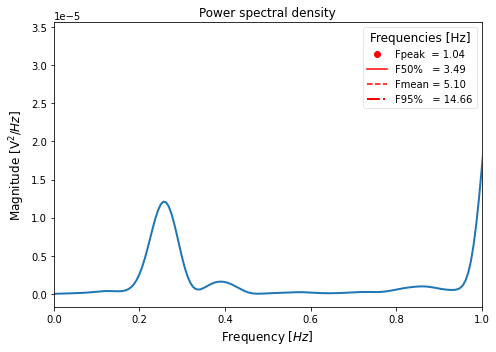

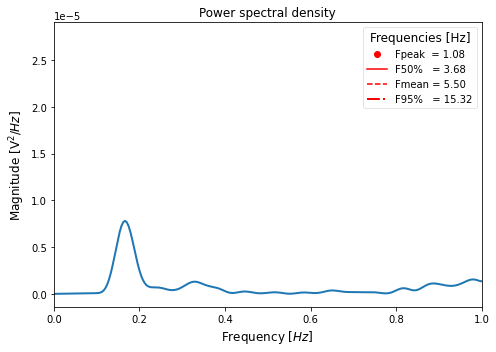

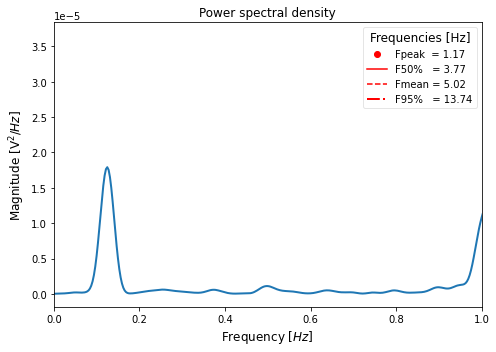

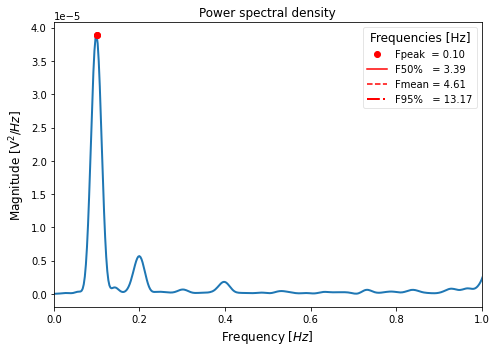

In [8]:
resp_period_all_comp = []

for k in time_frames:
    scg_cut = s6[int(k[0]*fs):int(k[1]*fs)]
    fpcntile, mpf, fmax, Ptotal, f, P = psd2(scg_cut-np.mean(scg_cut), fs=fs, nfft=8*np.ceil(len(scg_cut)/2), show=True, xlim=(0, 1))
    f_cut = np.where(f<=1)
    P_01 = P[f_cut]
    f_max01 = f[np.argmax(P_01)]
    resp_period = 1/f_max01
    resp_period_all_comp.append(resp_period)

Text(0.5, 1.0, 'Sub-A/BDC9/K-ICB_A_BDC9_20190331-111511_BKe5wNpmMCVETk\nMAE: 0.75s')

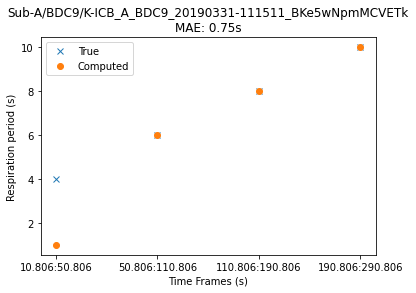

In [9]:
main_path = os.path.normpath(measurement)
sec_path = main_path.split(os.sep)
sec_path = sec_path[7]+'/'+sec_path[8]+'/'+sec_path[9]

resp_period_all_true = [4, 6, 8, 10]
err = mean_absolute_error(resp_period_all_true, resp_period_all_comp)
plt.figure()
x = np.array([0,1,2,3])
my_xticks = ['10.806:50.806','50.806:110.806','110.806:190.806','190.806:290.806']
plt.xticks(x, my_xticks)
plt.plot(my_xticks, resp_period_all_true, 'x')
plt.plot(my_xticks, resp_period_all_comp, 'o')
plt.xlabel('Time Frames (s)')
plt.ylabel("Respiration period (s)")
plt.legend(['True', 'Computed'])
plt.title(sec_path+ '\nMAE: ' +str(format(err, ".2f"))+ 's')

For all measurements.

In [10]:
del path_all[96]
del path_all[227]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


/tmp/ipykernel_38534/3904625002.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263


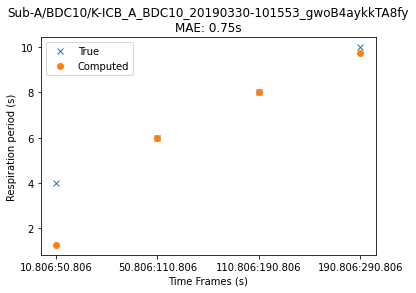

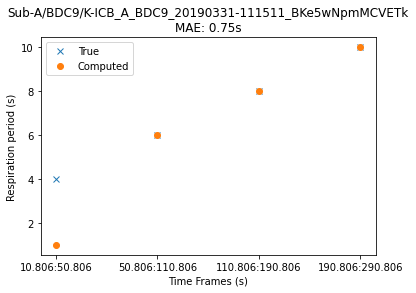

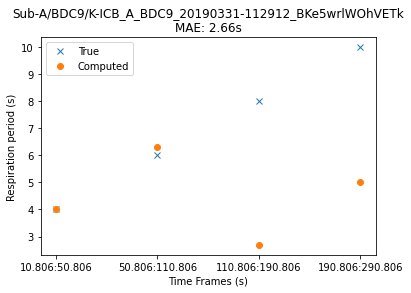

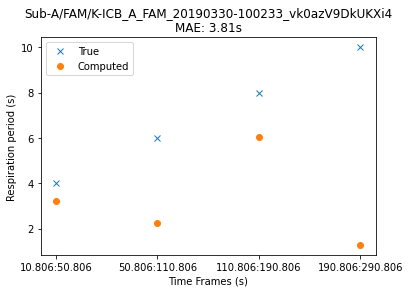

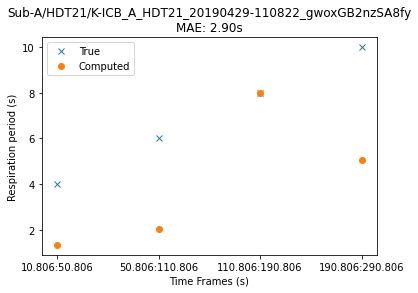

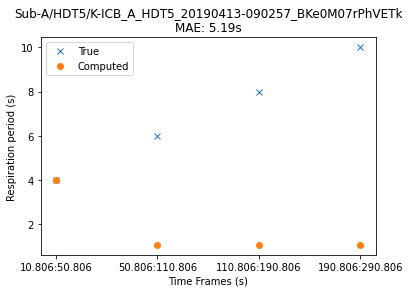

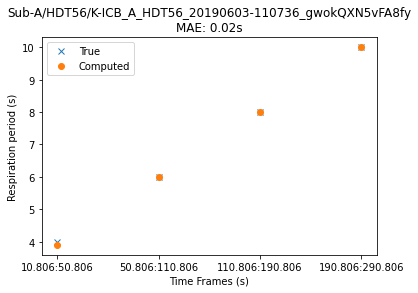

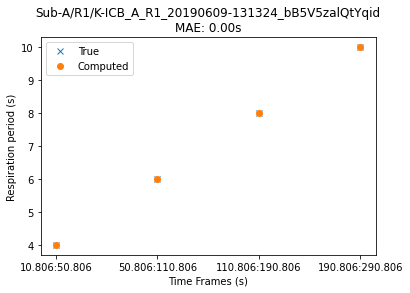

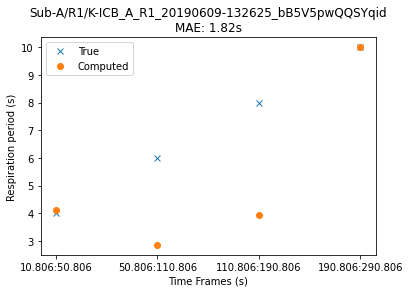

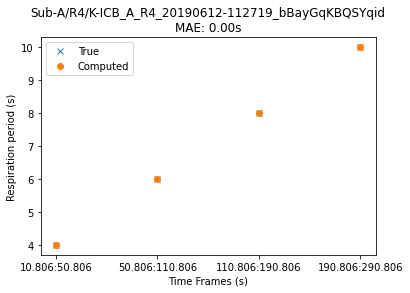

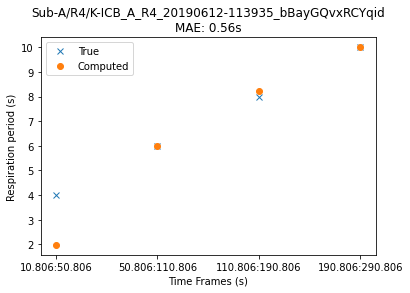

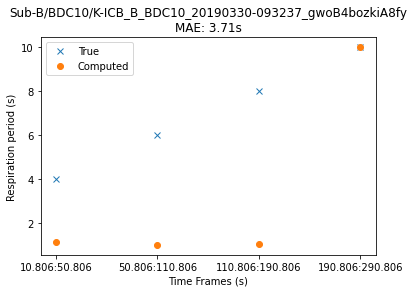

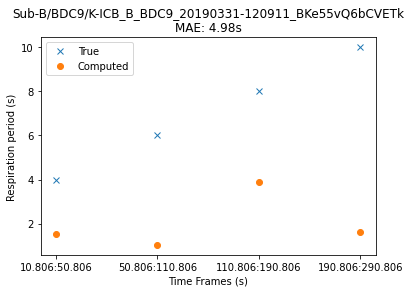

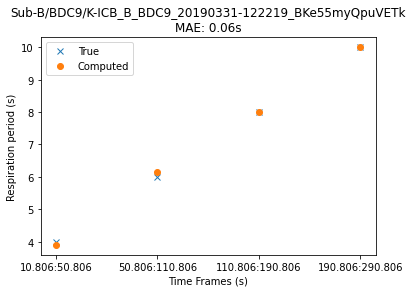

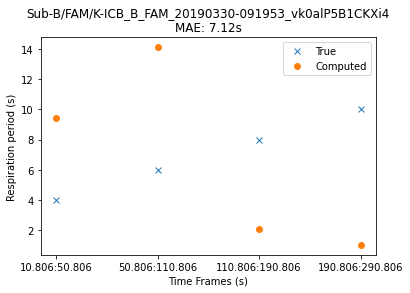

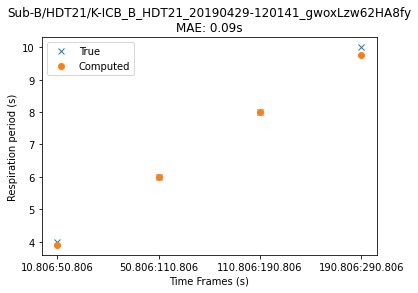

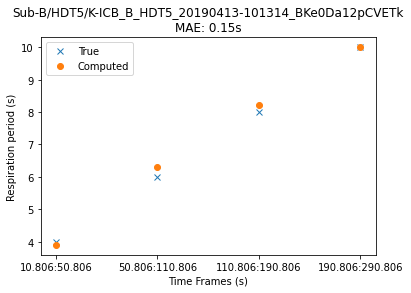

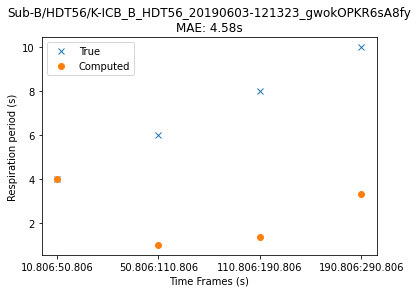

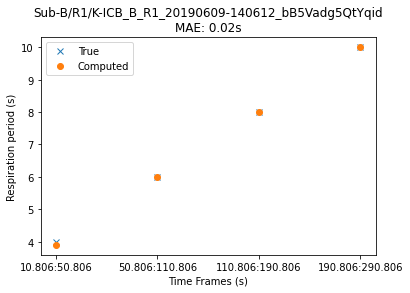

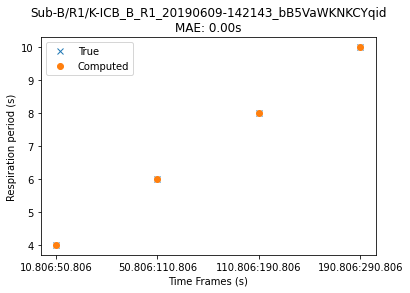

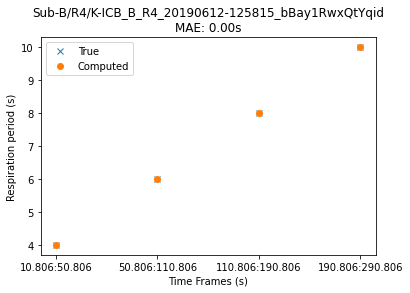

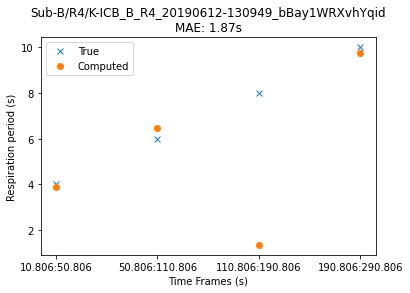

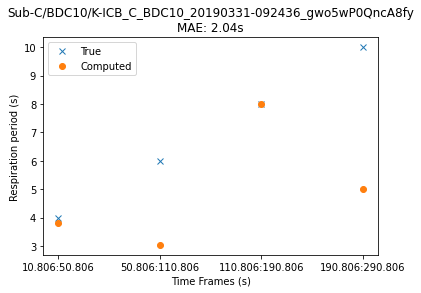

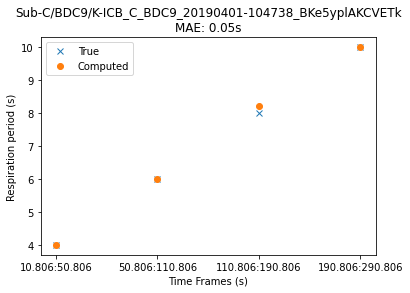

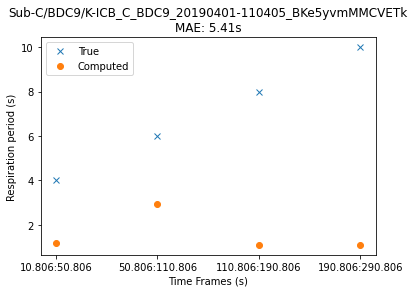

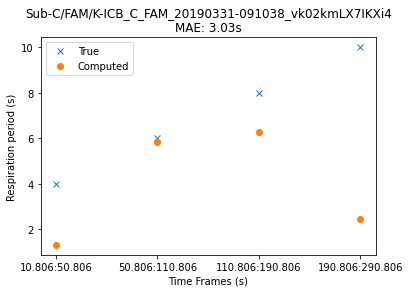

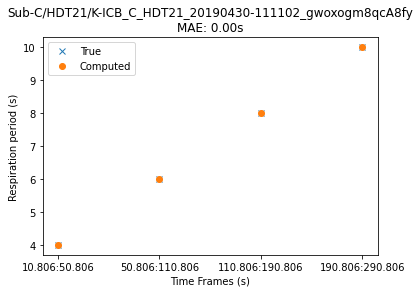

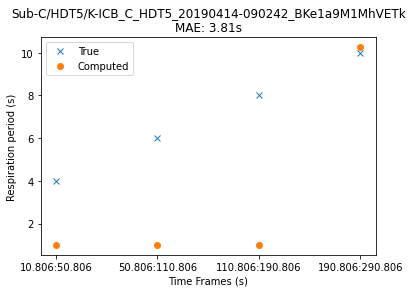

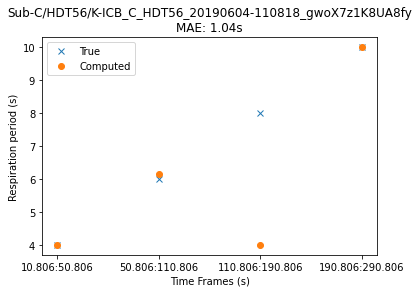

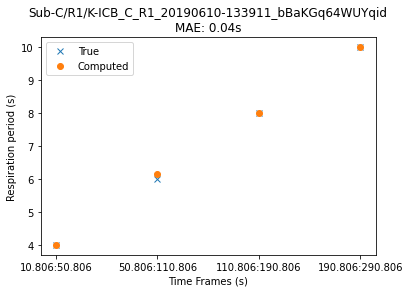

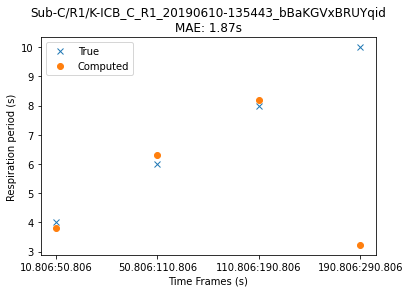

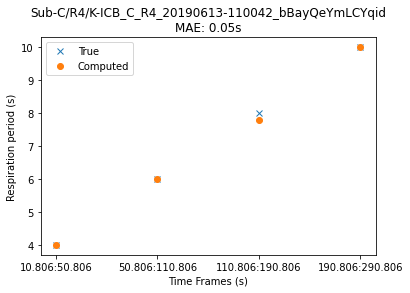

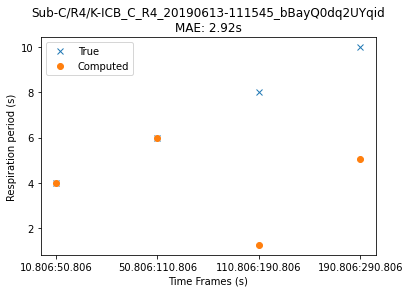

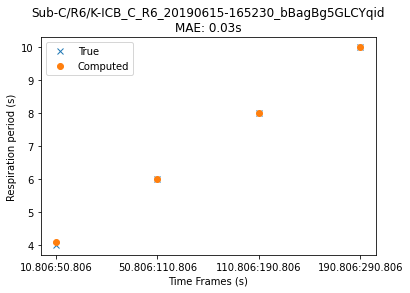

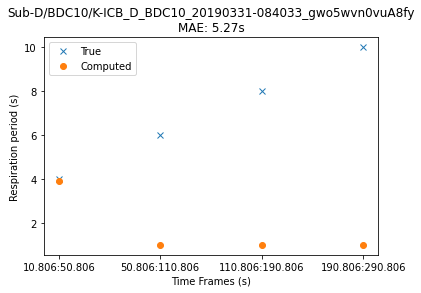

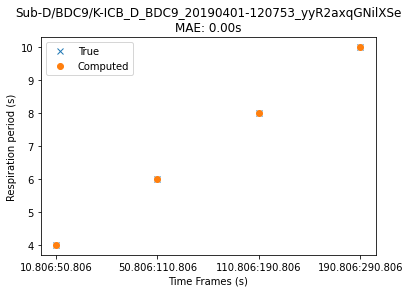

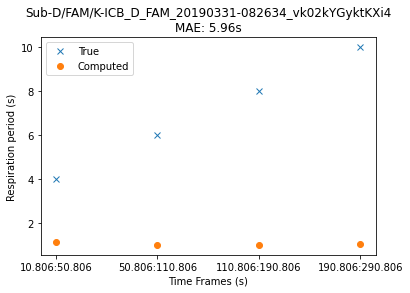

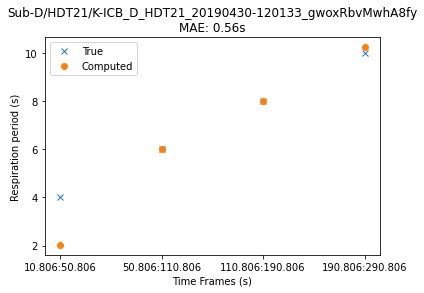

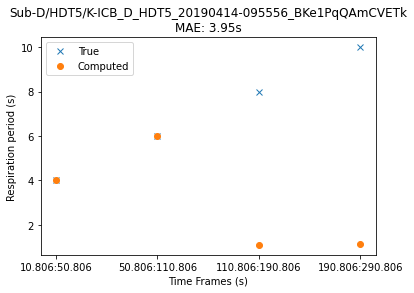

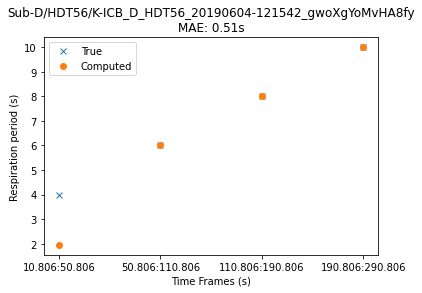

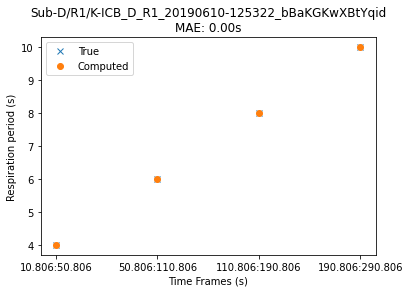

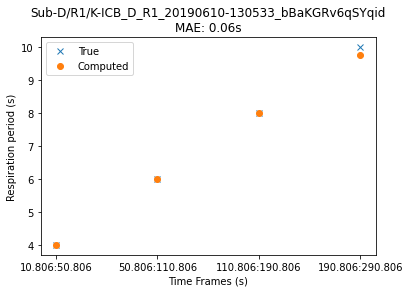

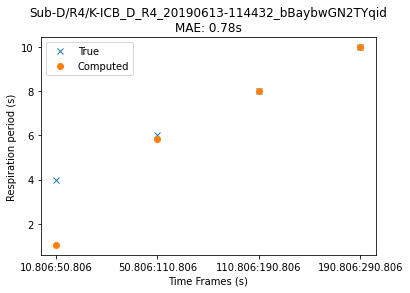

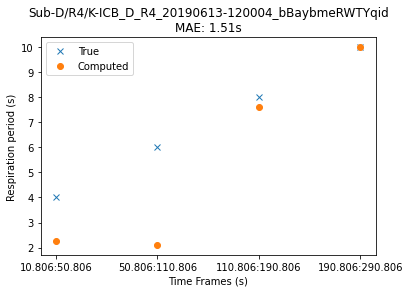

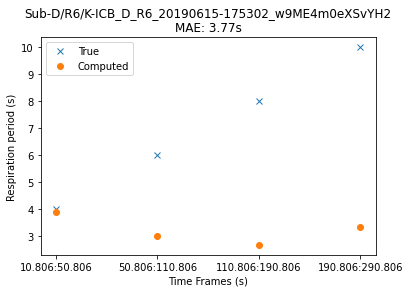

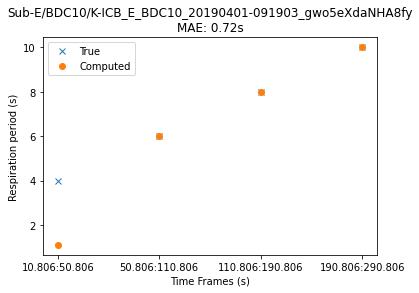

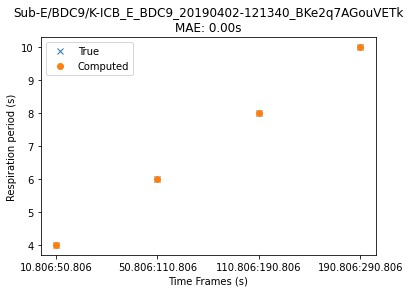

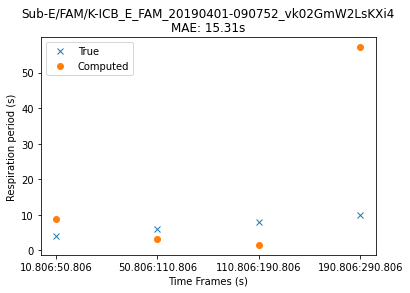

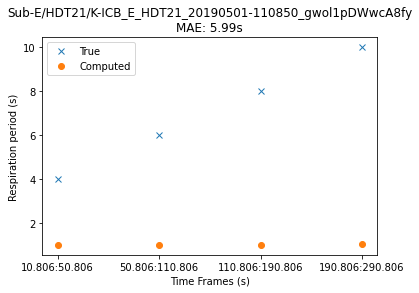

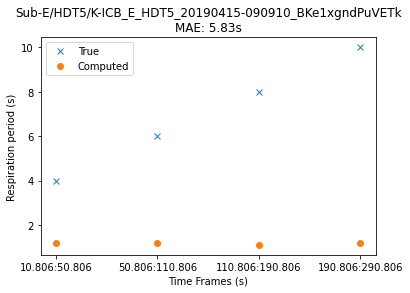

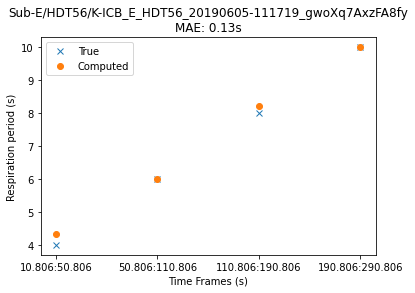

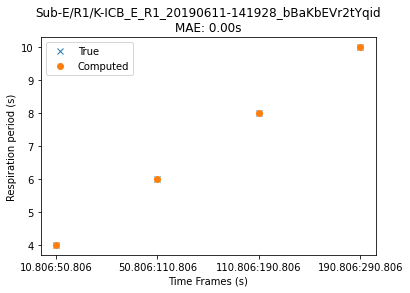

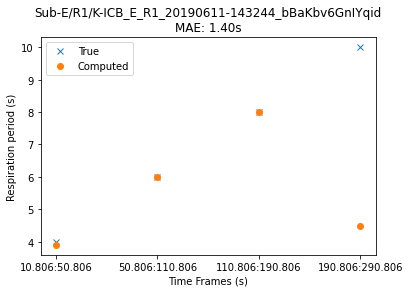

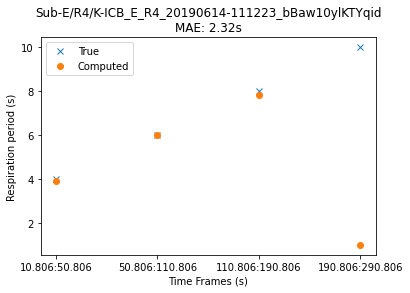

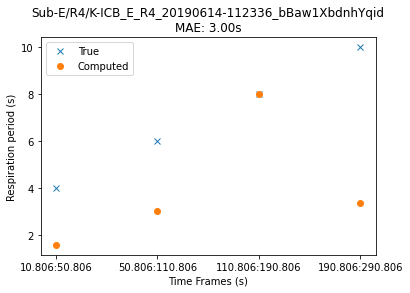

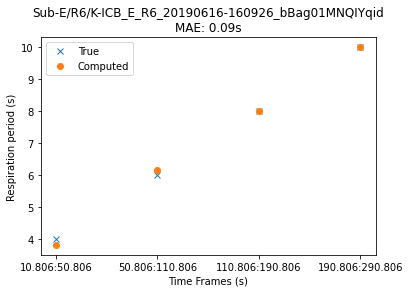

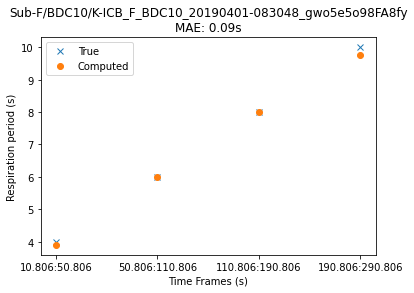

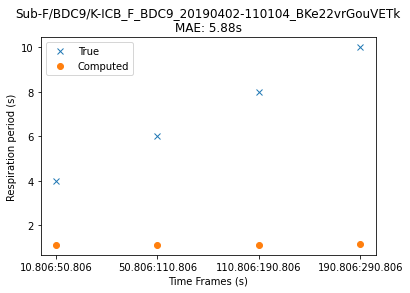

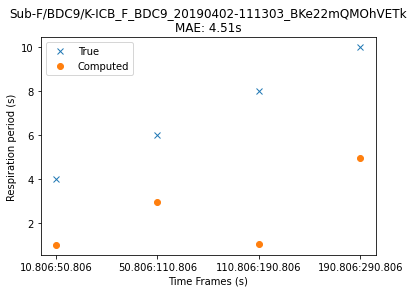

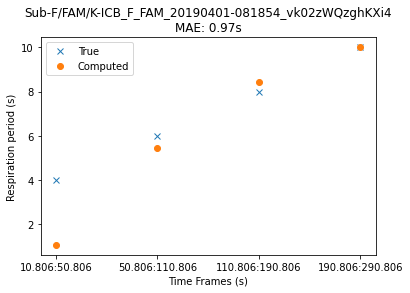

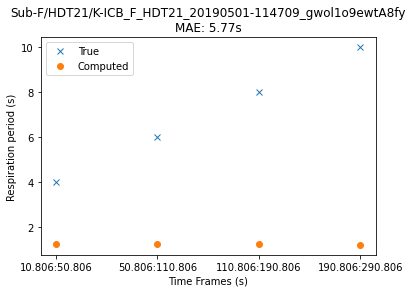

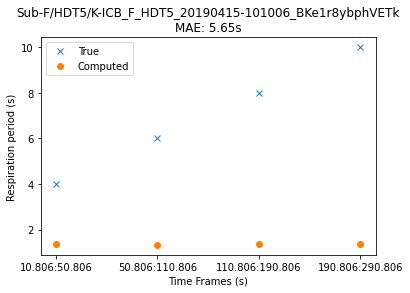

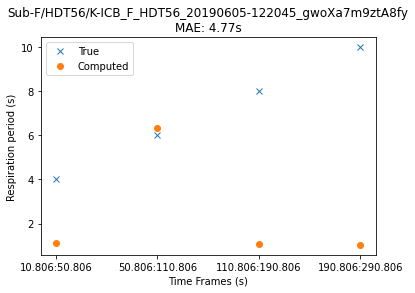

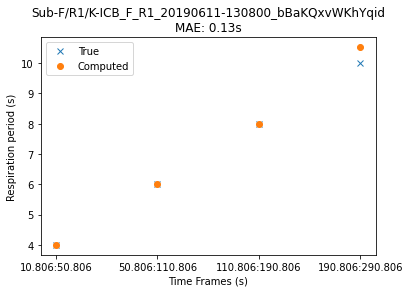

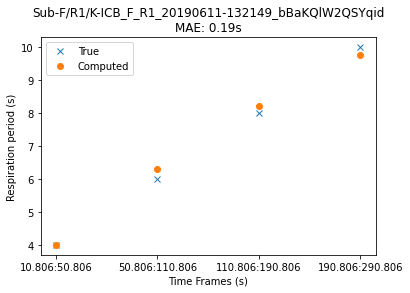

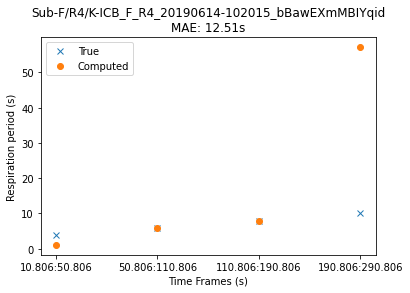

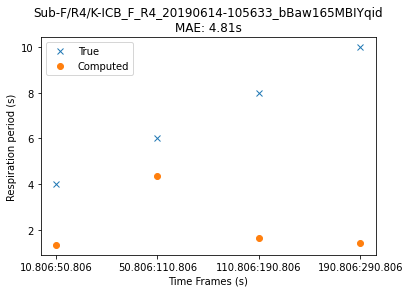

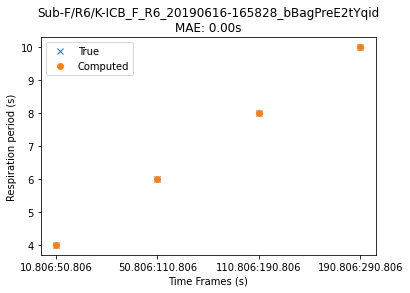

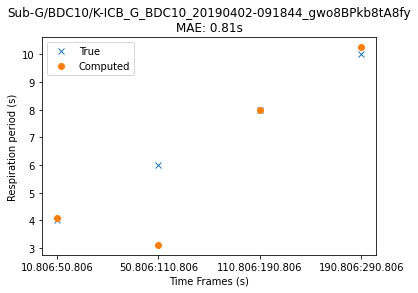

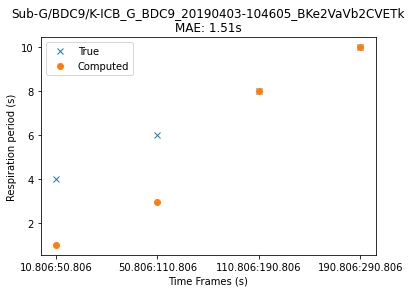

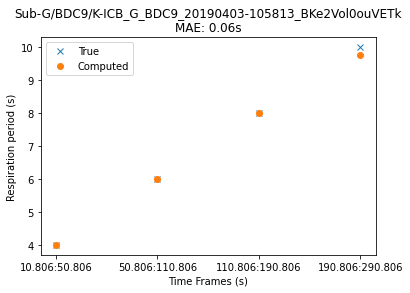

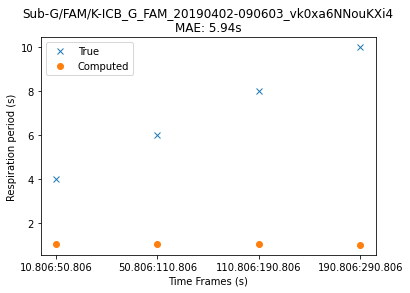

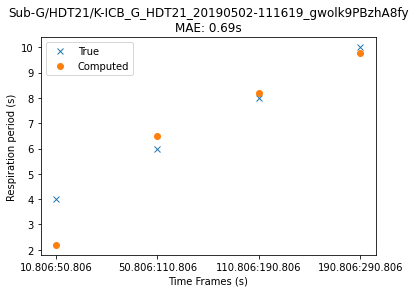

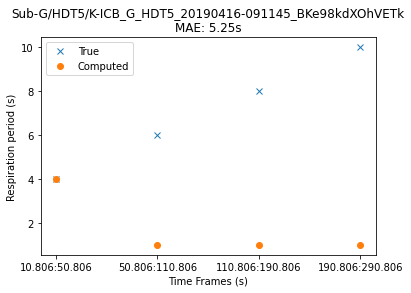

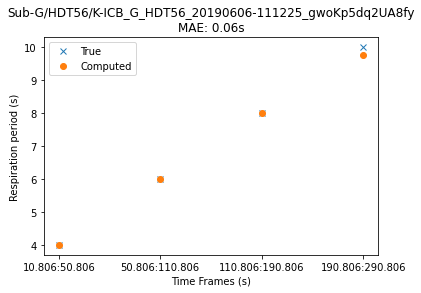

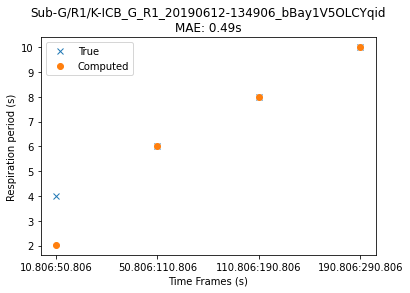

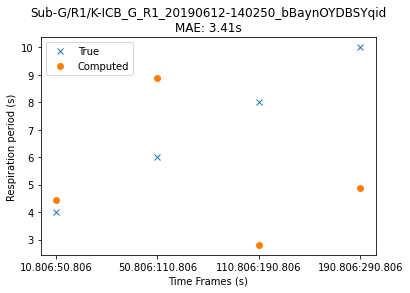

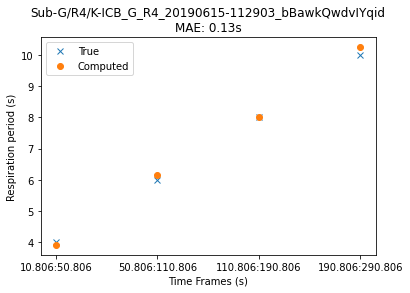

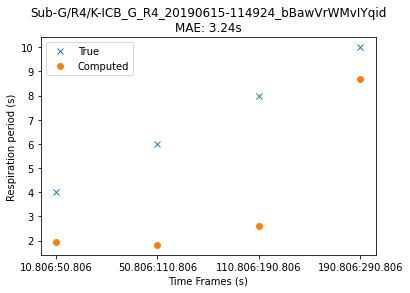

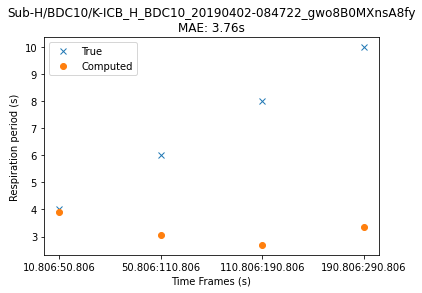

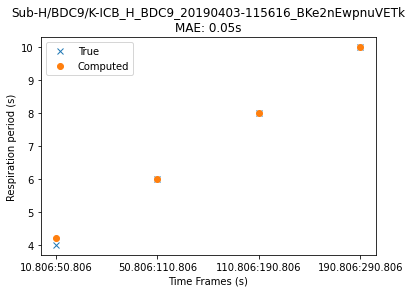

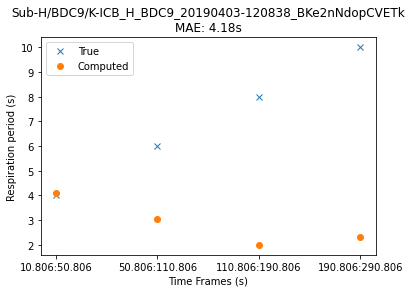

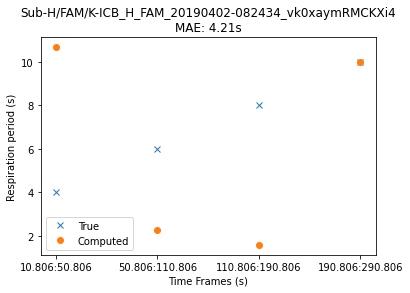

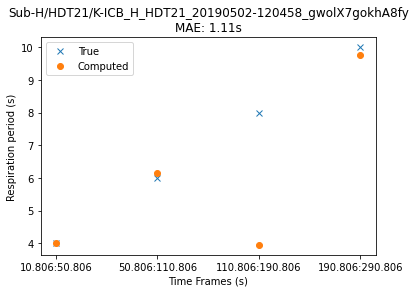

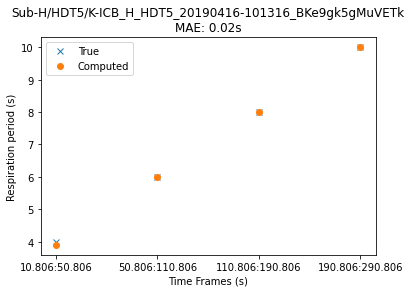

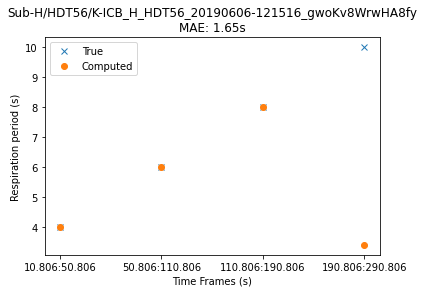

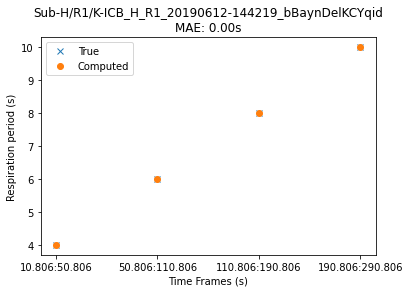

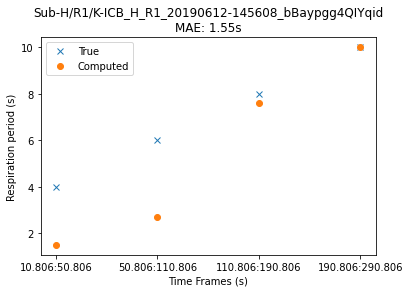

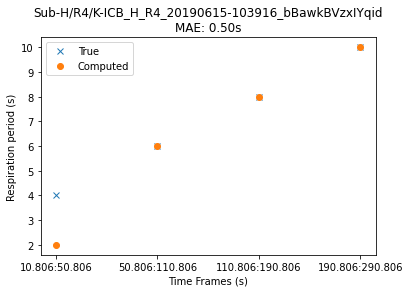

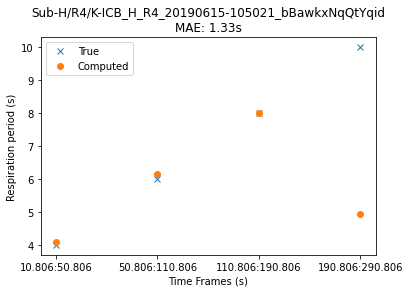

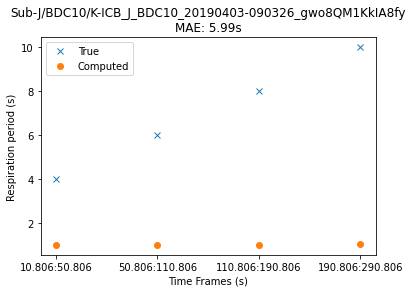

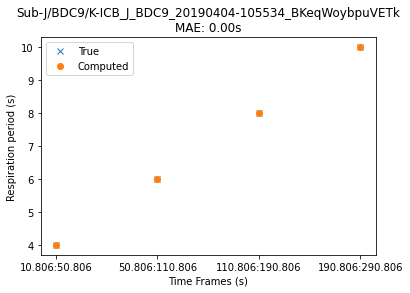

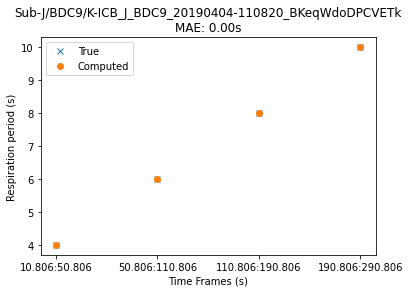

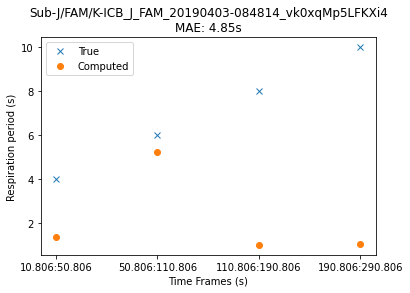

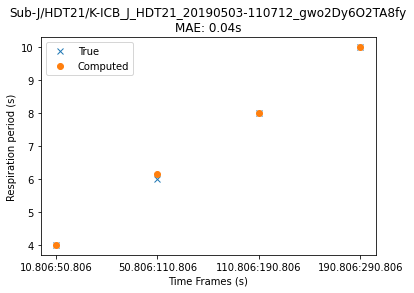

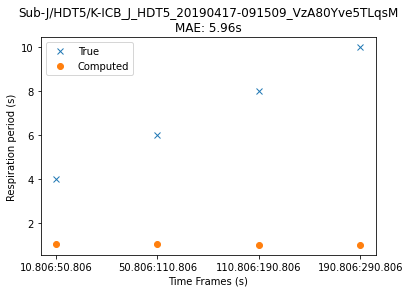

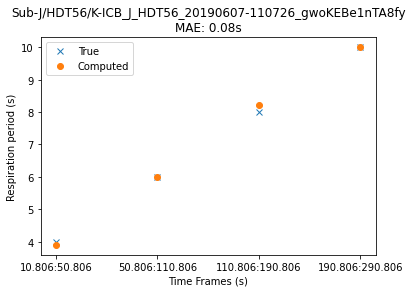

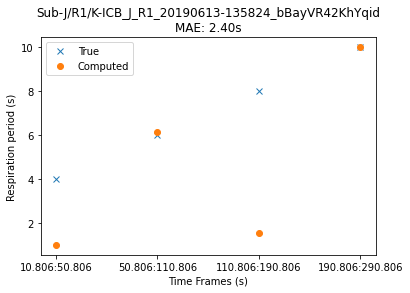

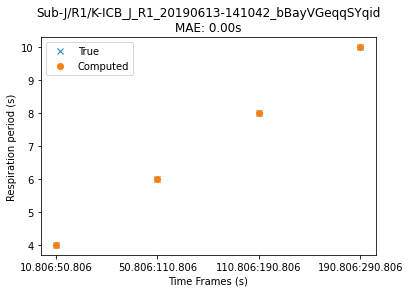

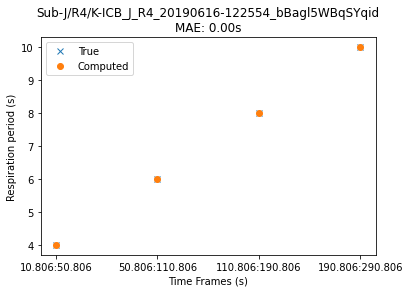

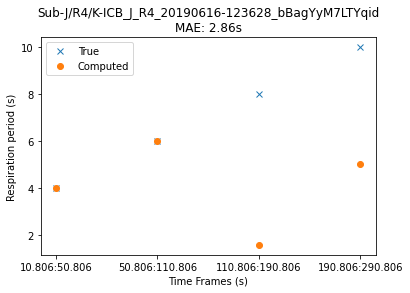

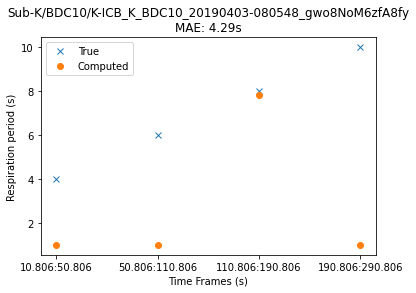

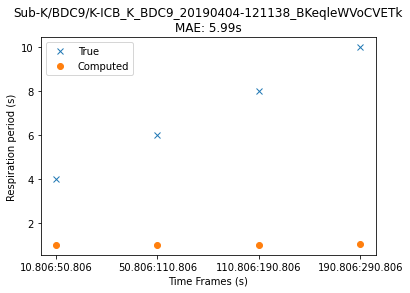

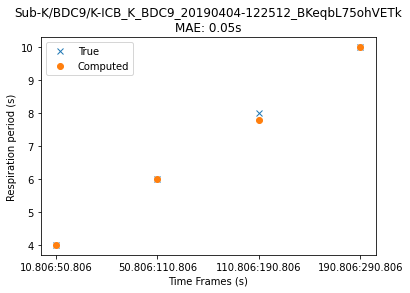

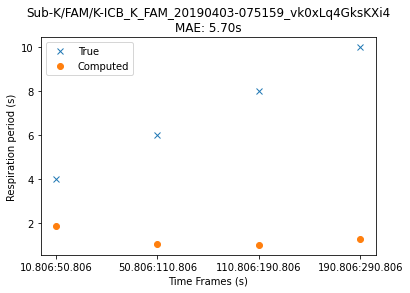

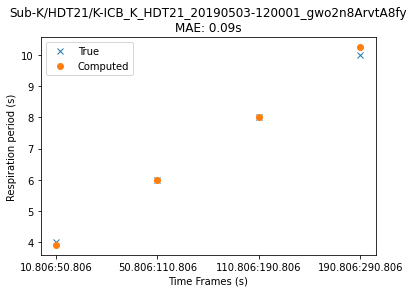

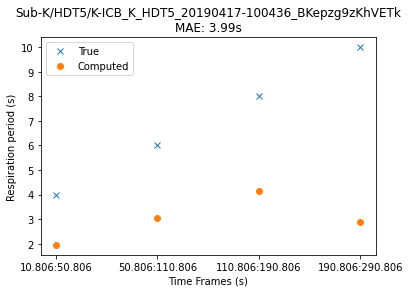

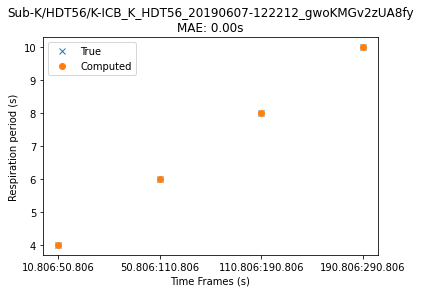

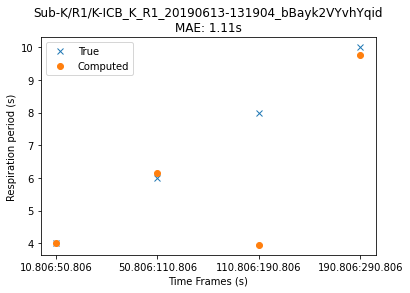

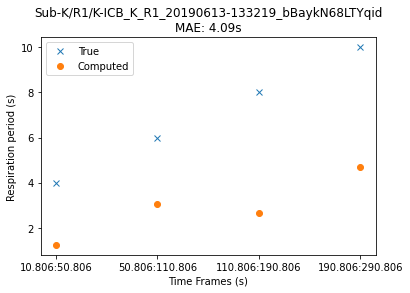

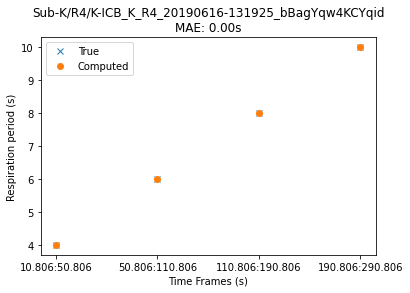

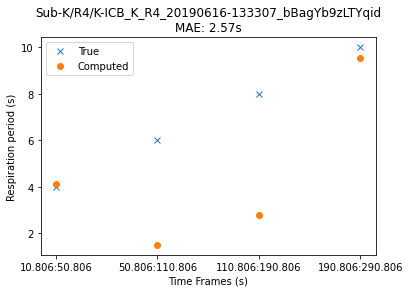

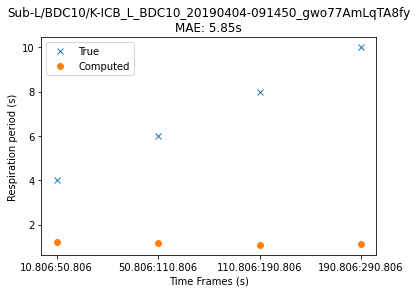

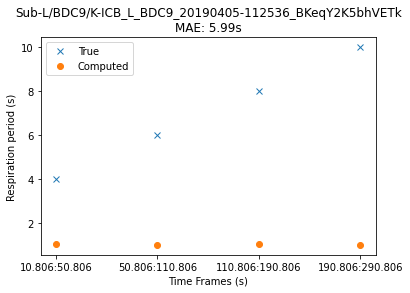

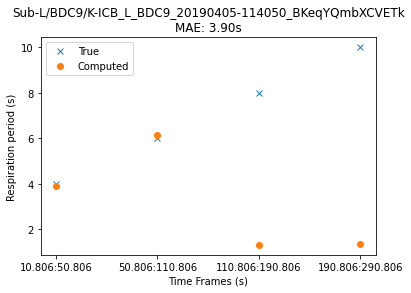

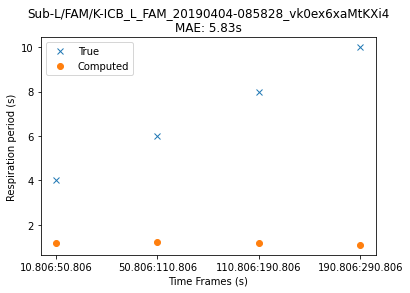

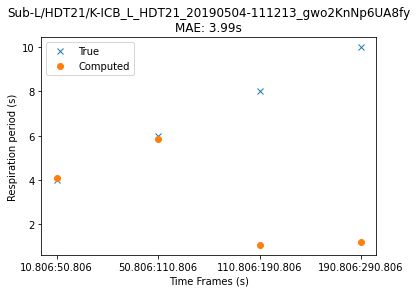

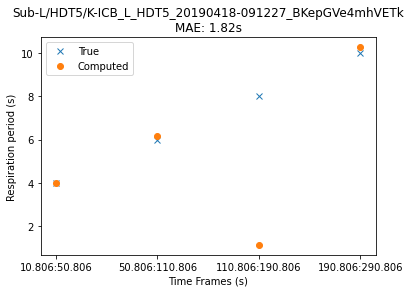

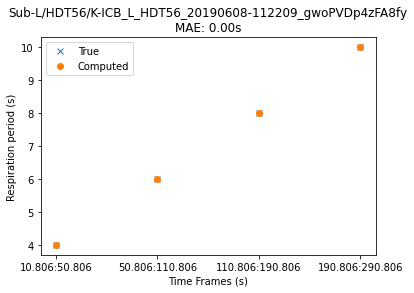

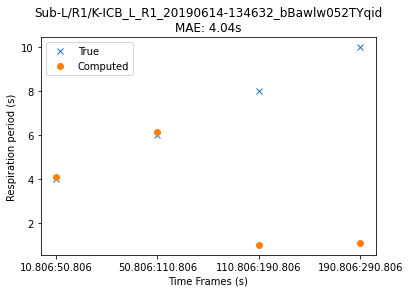

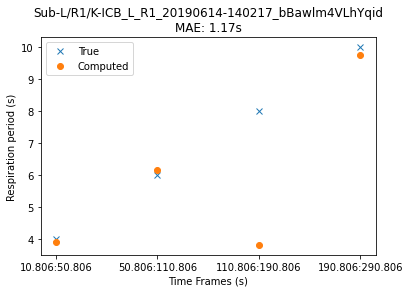

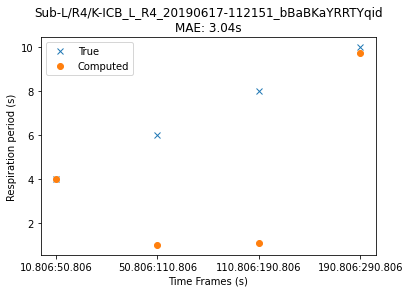

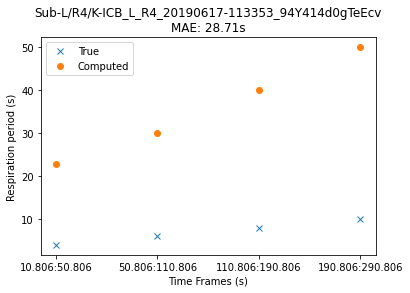

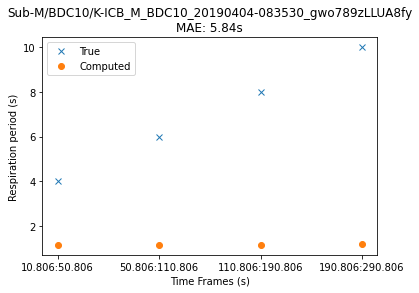

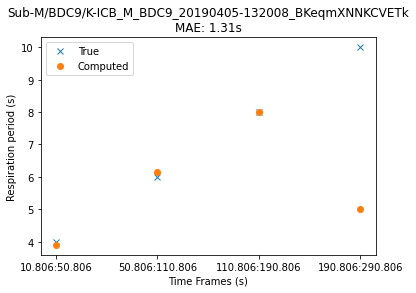

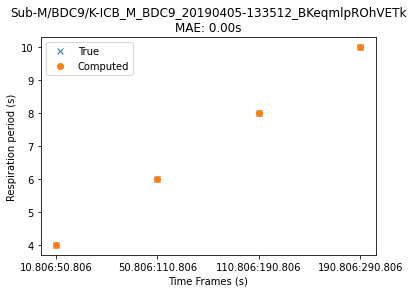

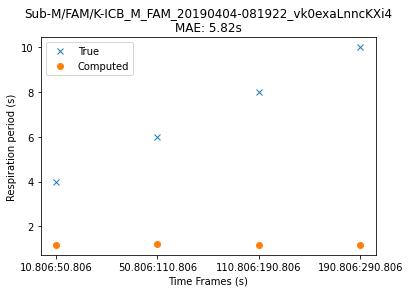

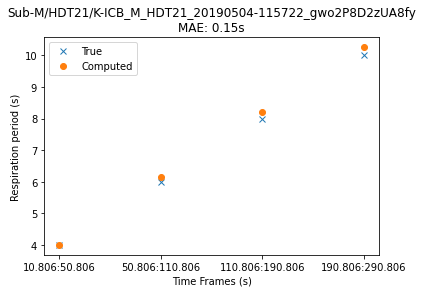

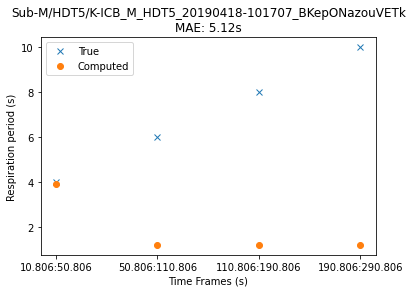

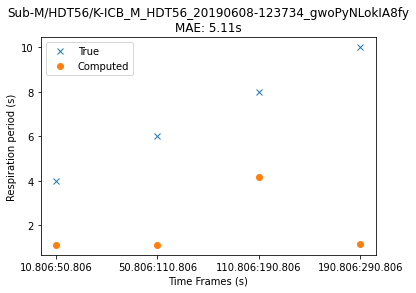

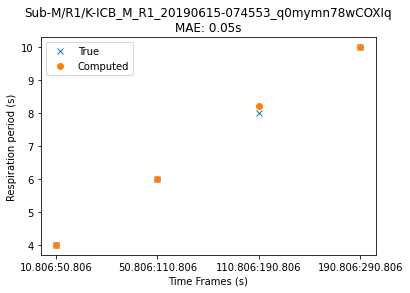

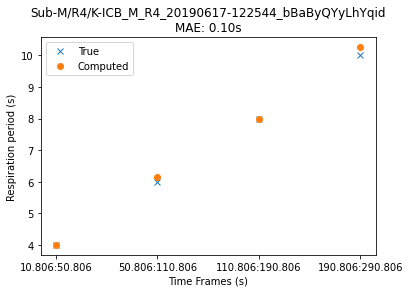

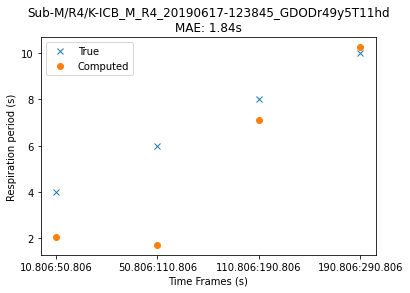

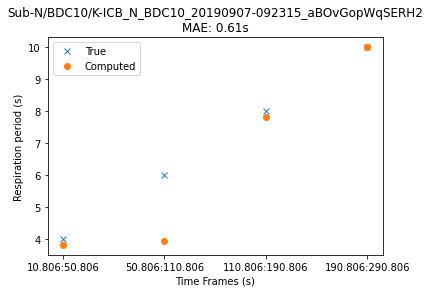

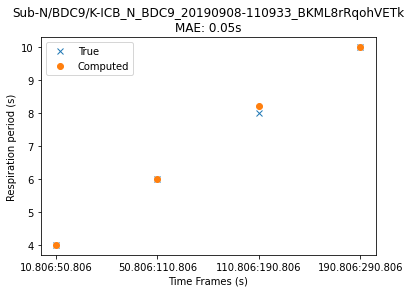

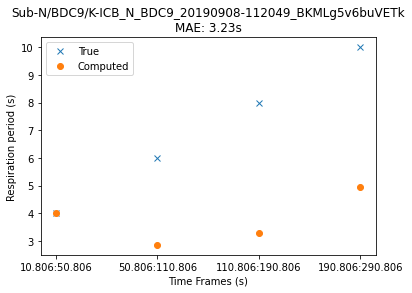

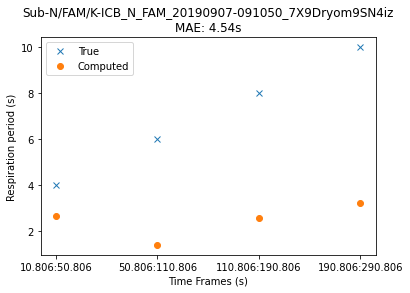

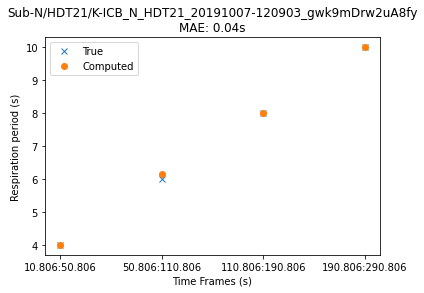

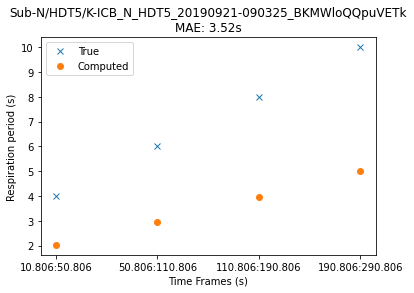

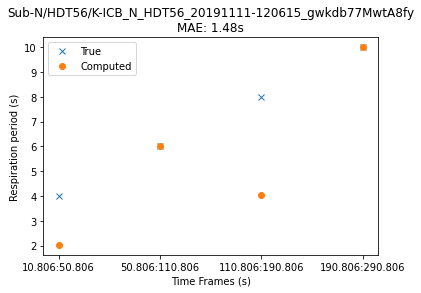

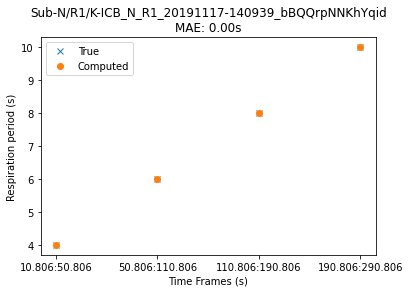

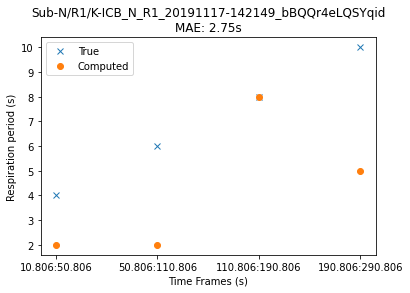

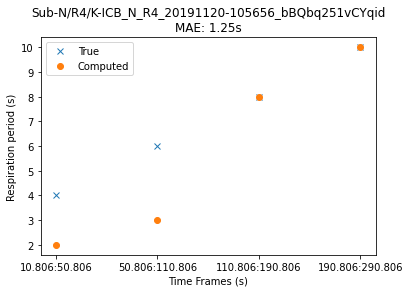

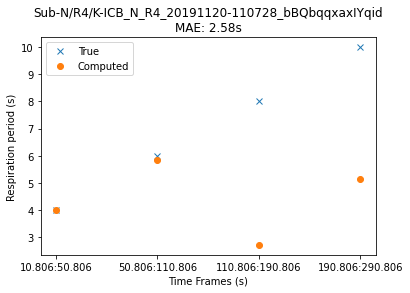

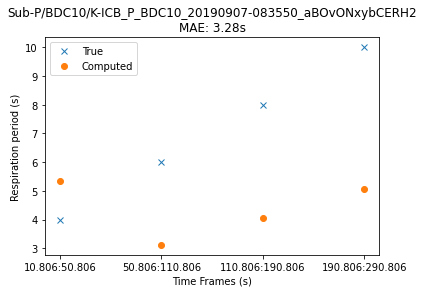

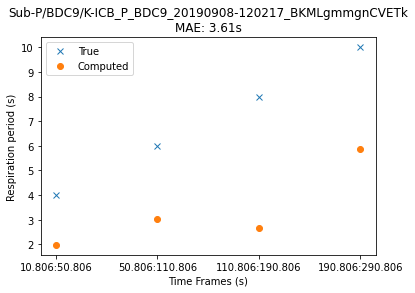

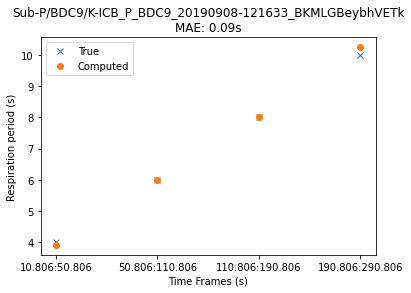

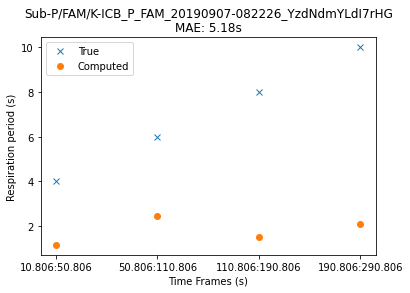

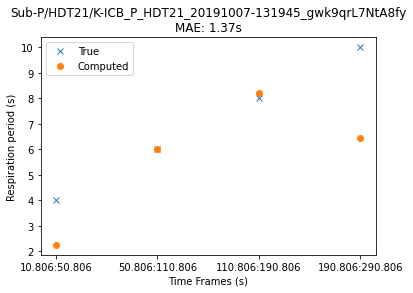

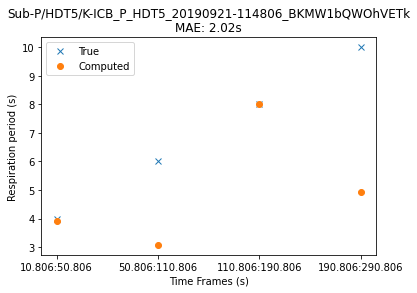

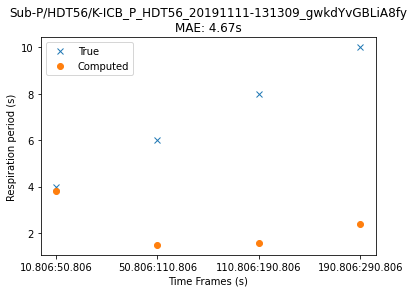

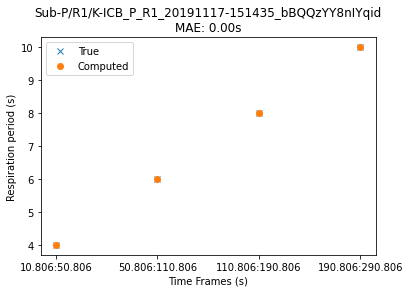

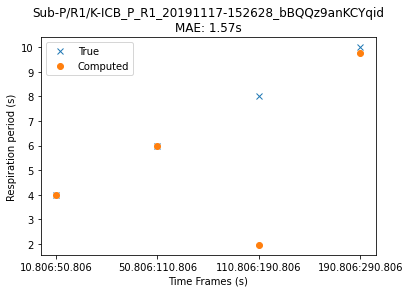

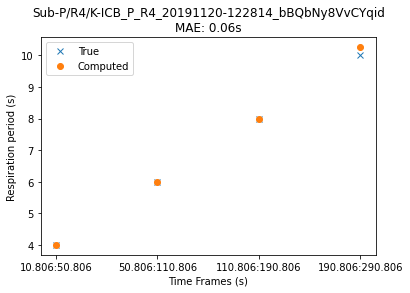

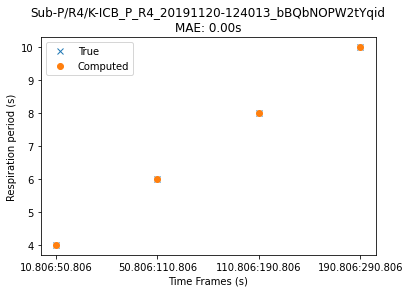

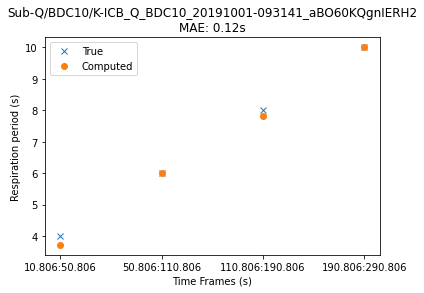

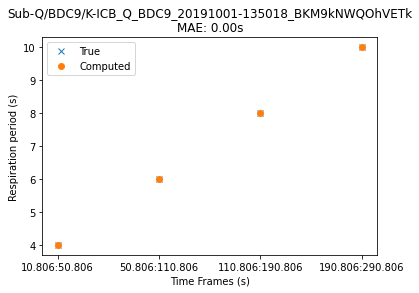

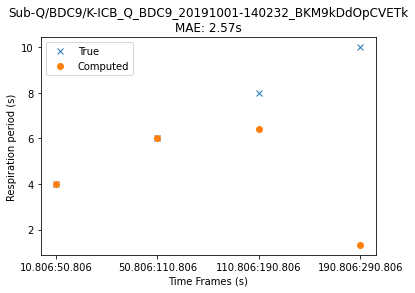

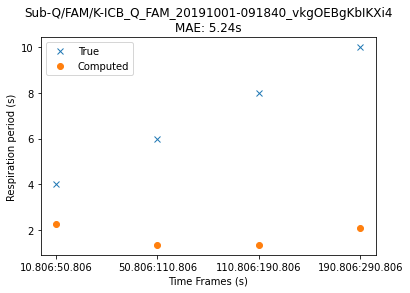

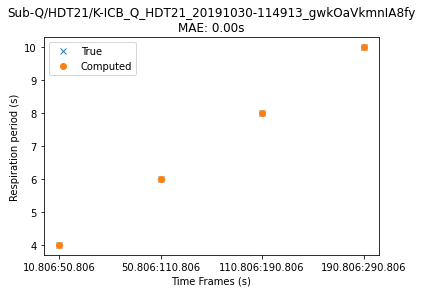

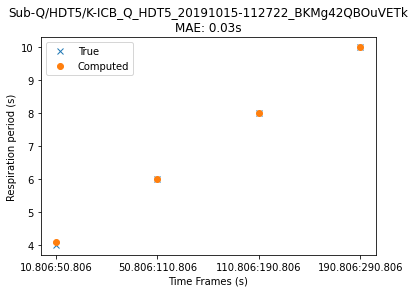

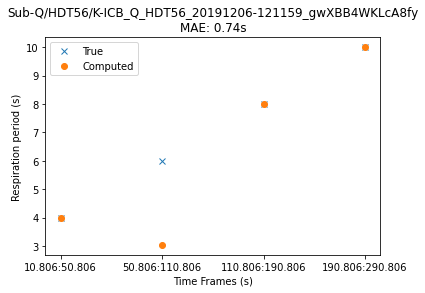

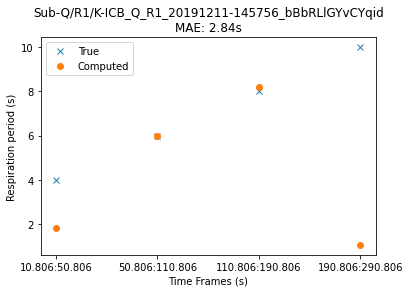

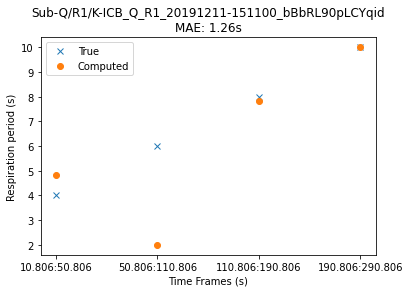

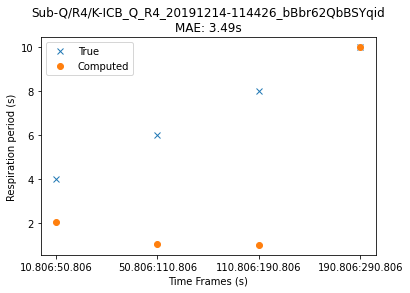

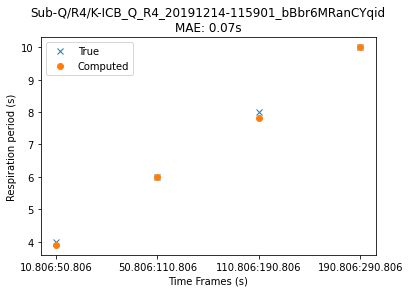

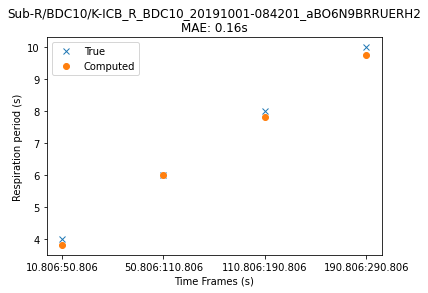

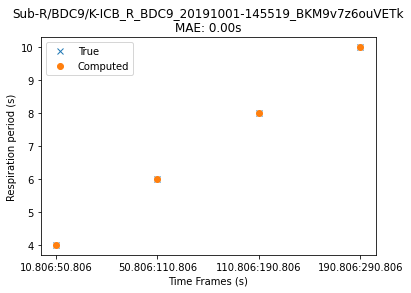

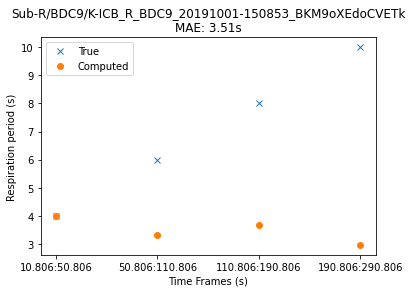

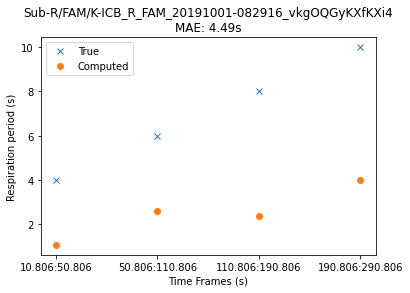

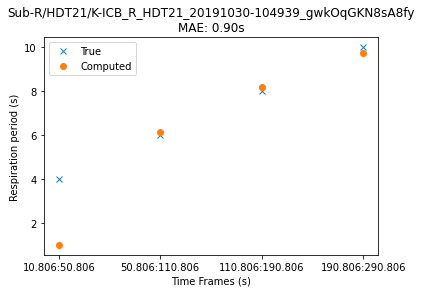

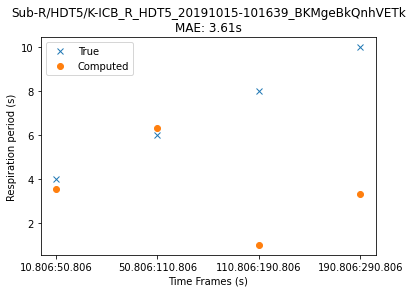

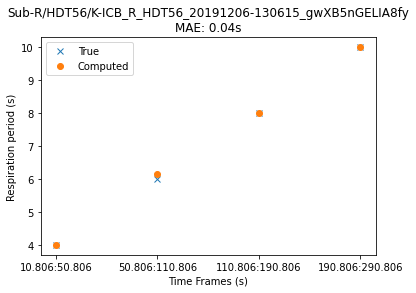

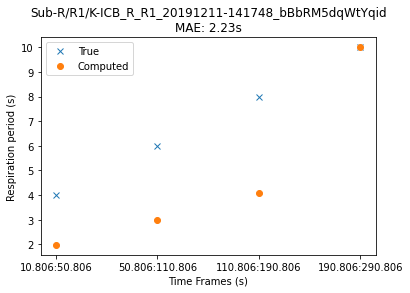

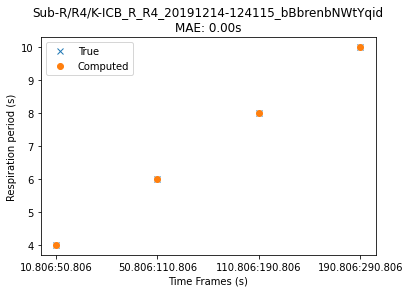

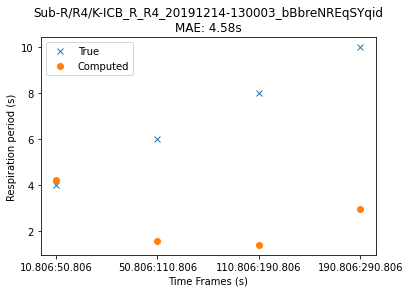

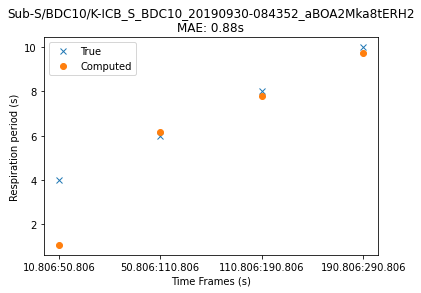

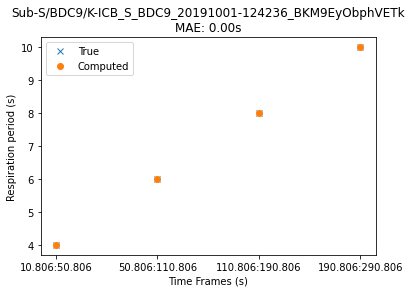

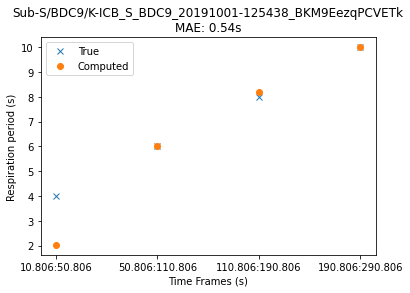

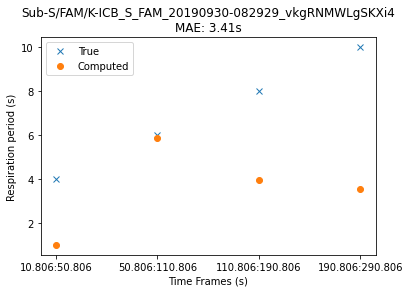

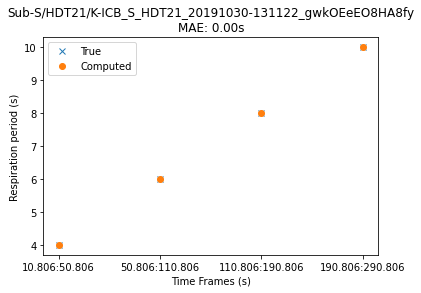

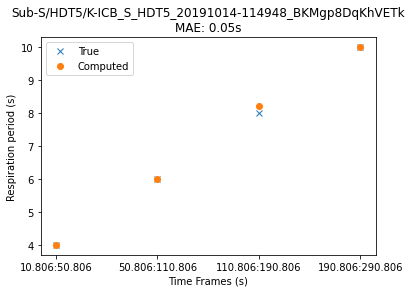

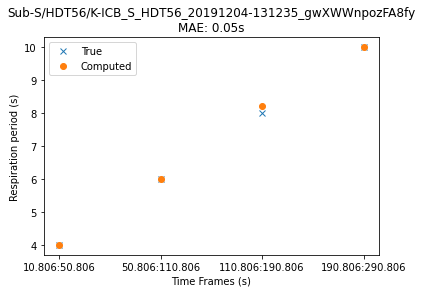

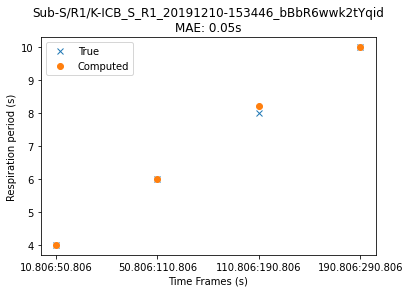

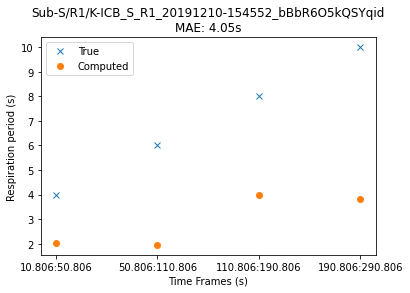

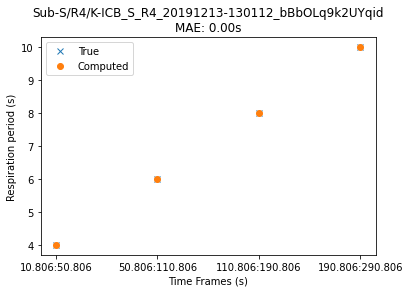

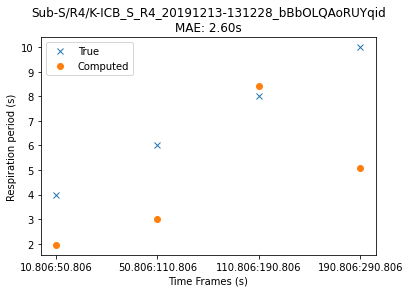

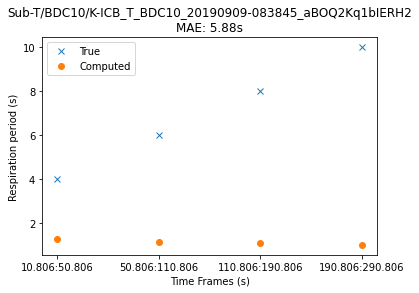

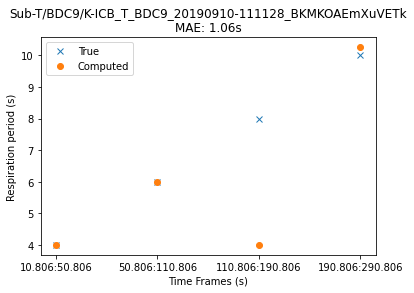

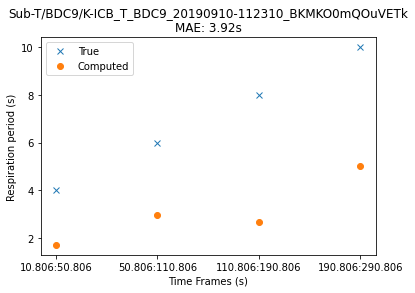

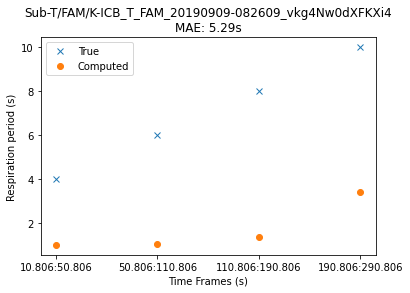

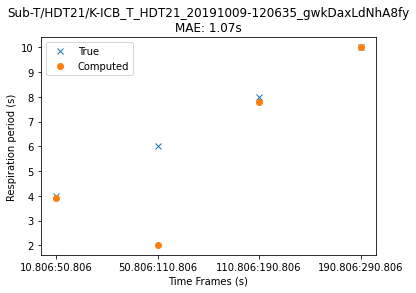

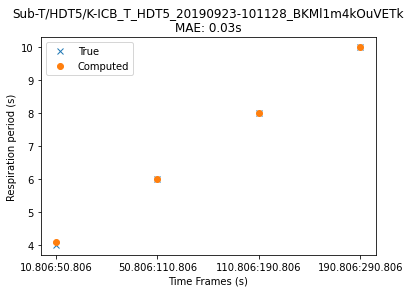

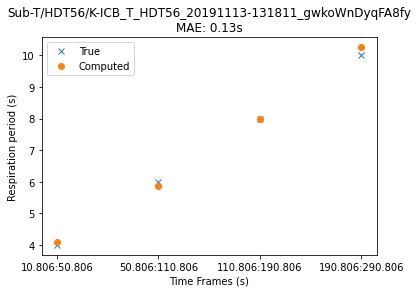

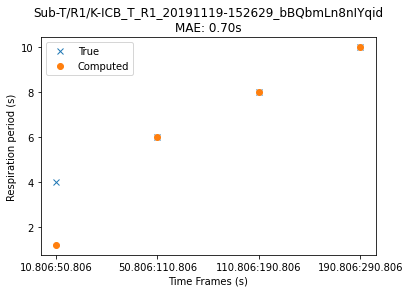

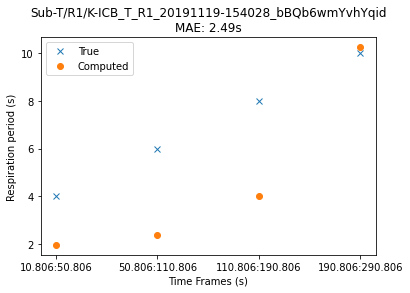

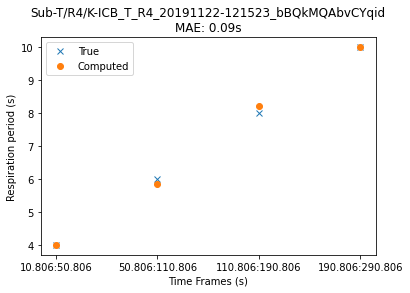

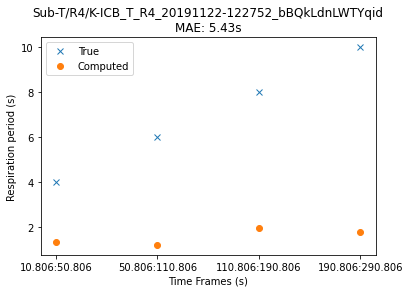

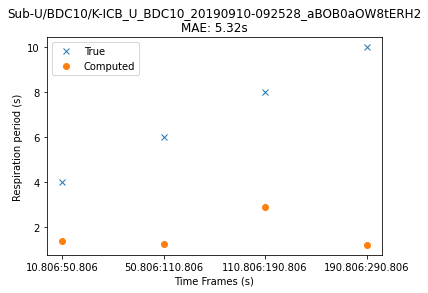

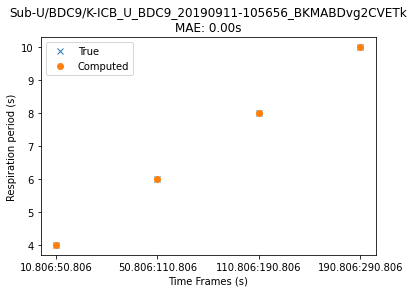

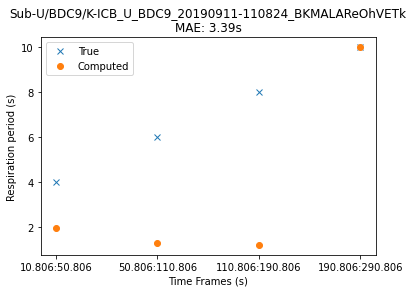

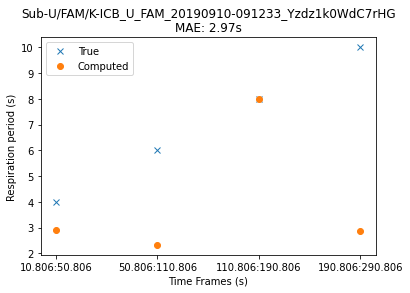

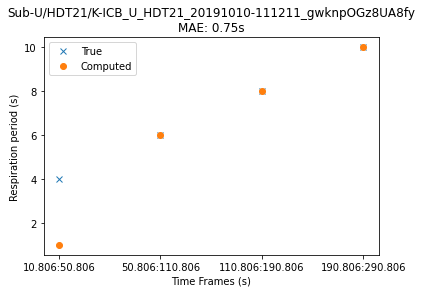

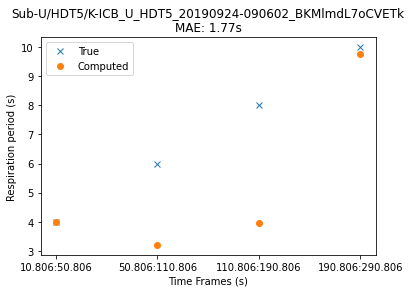

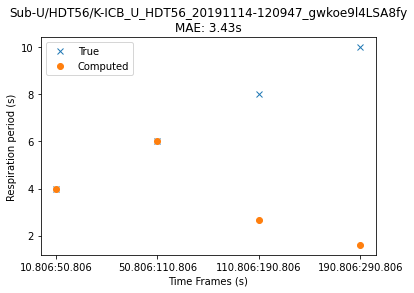

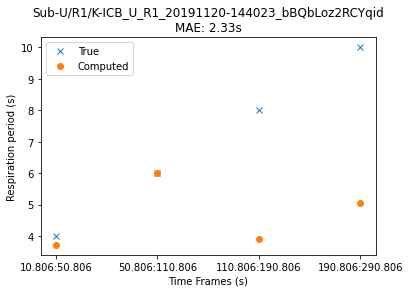

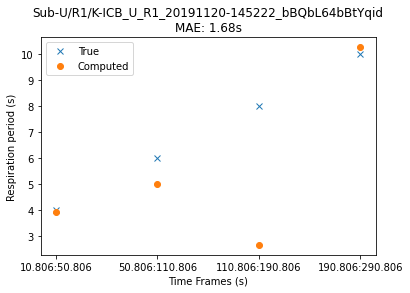

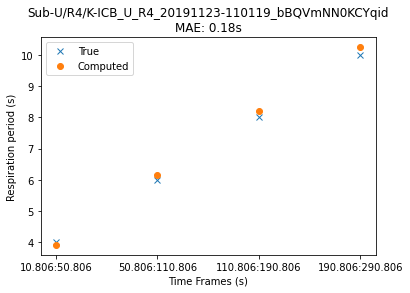

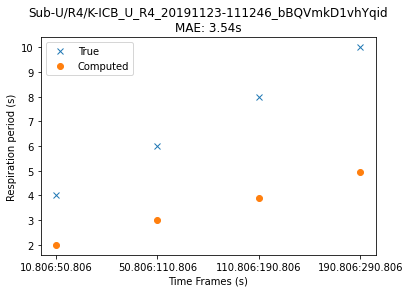

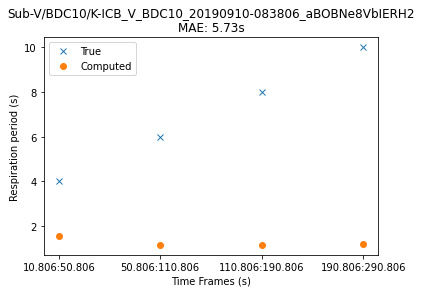

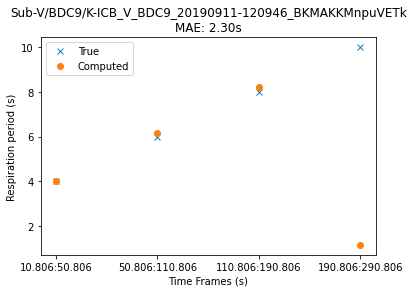

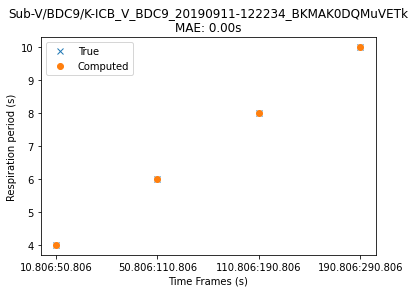

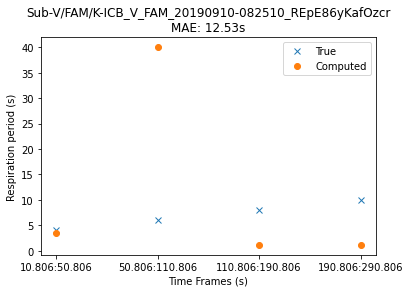

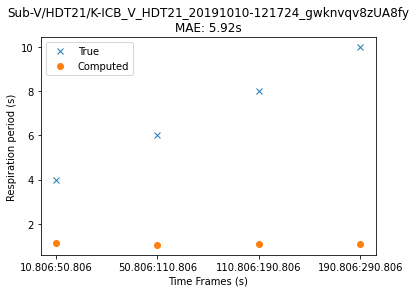

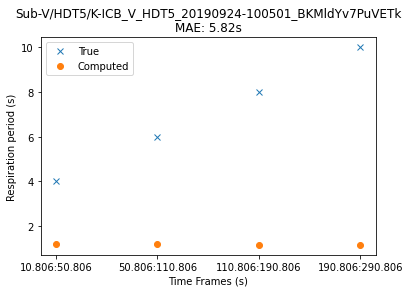

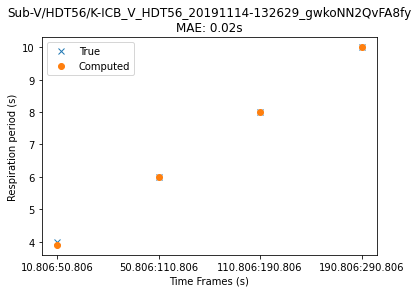

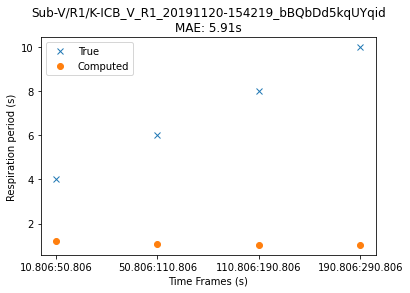

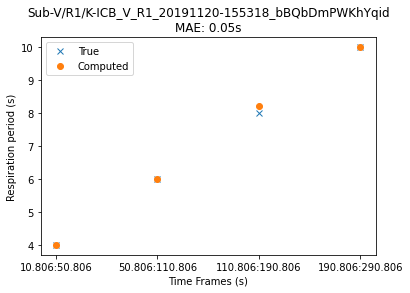

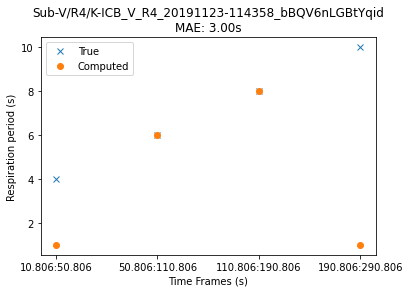

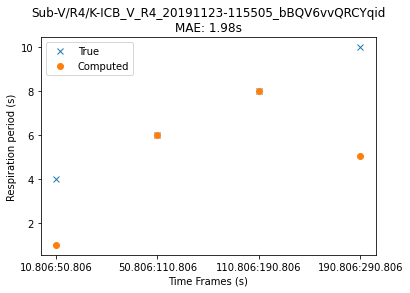

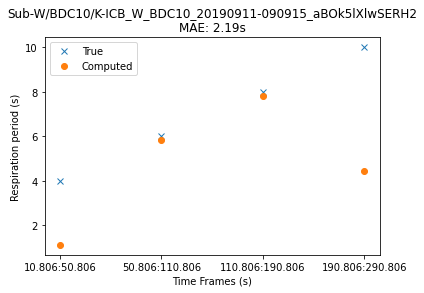

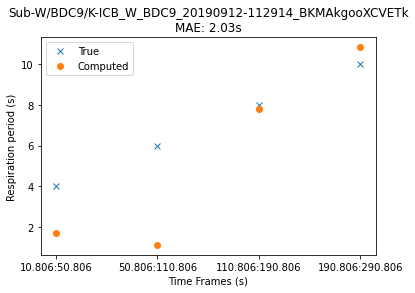

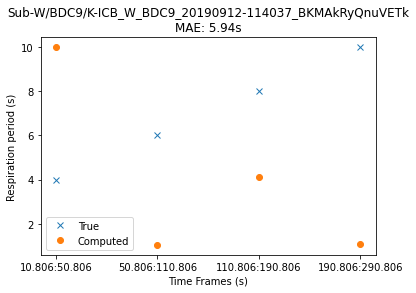

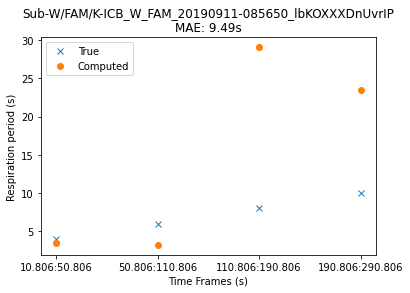

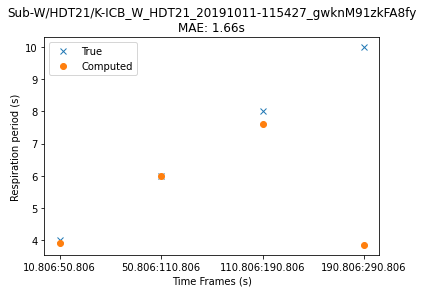

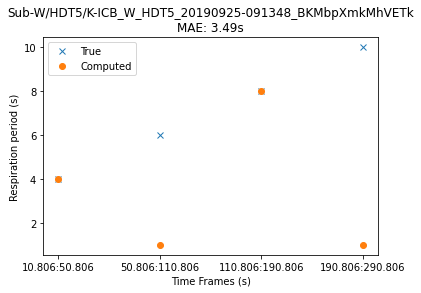

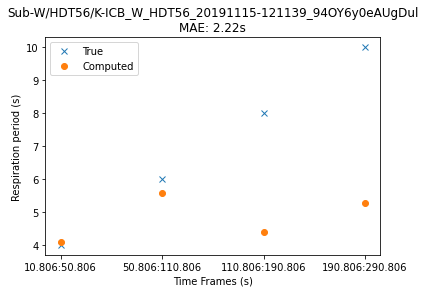

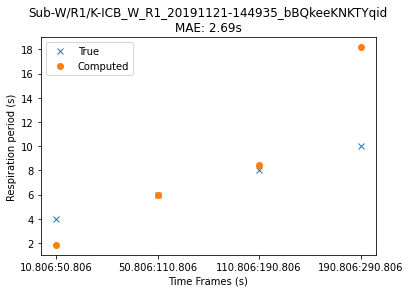

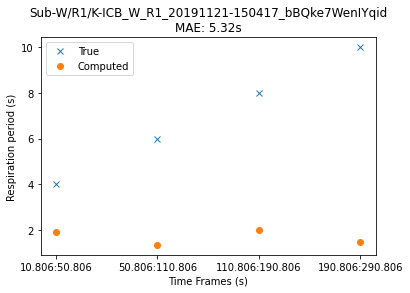

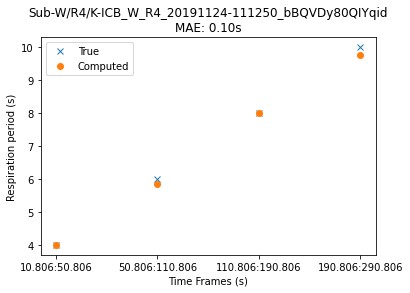

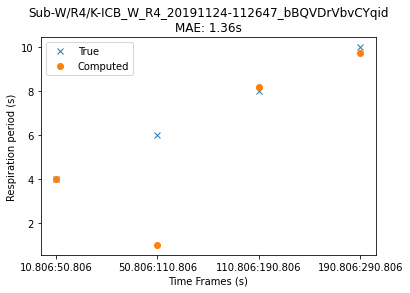

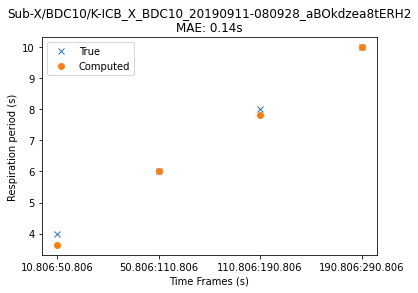

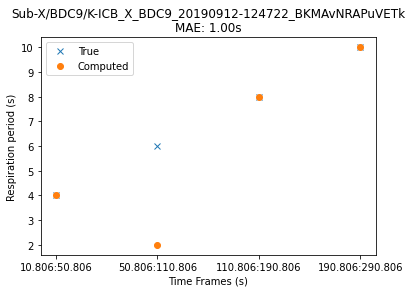

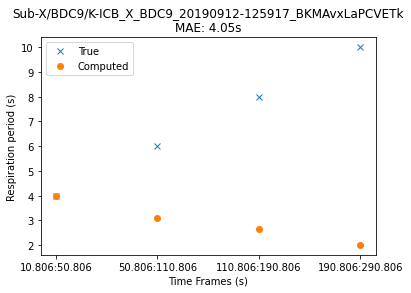

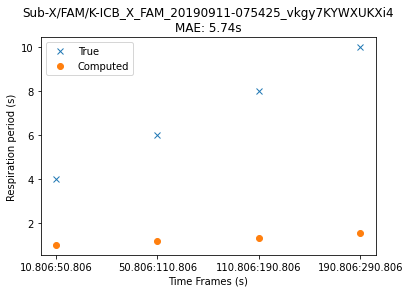

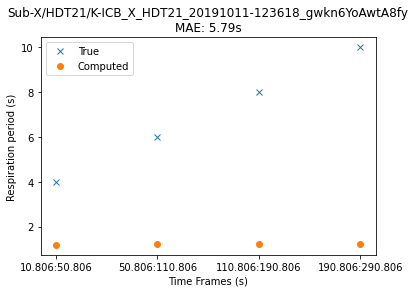

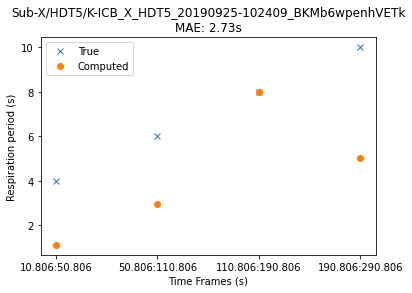

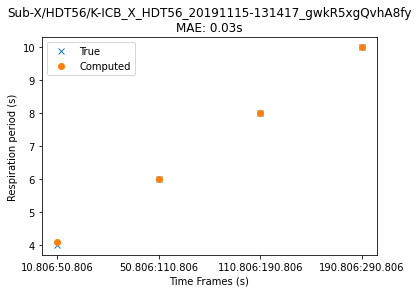

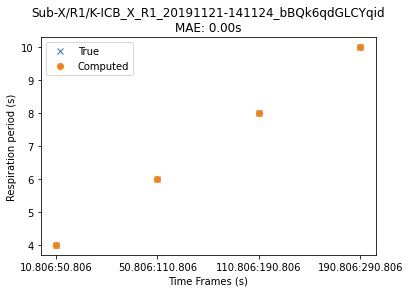

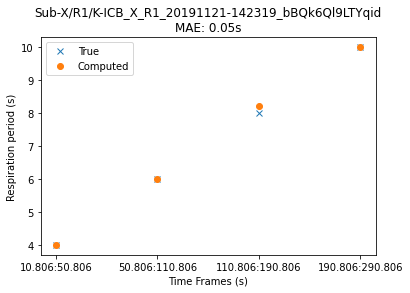

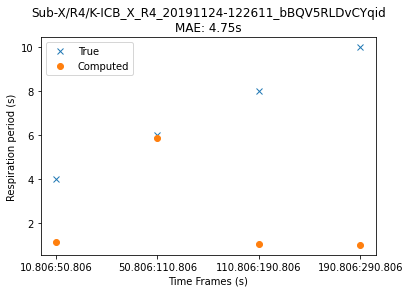

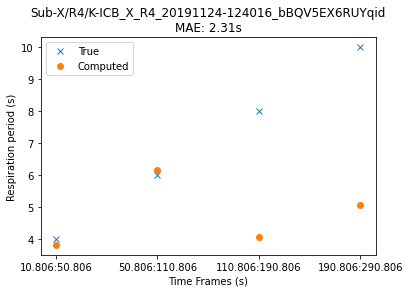

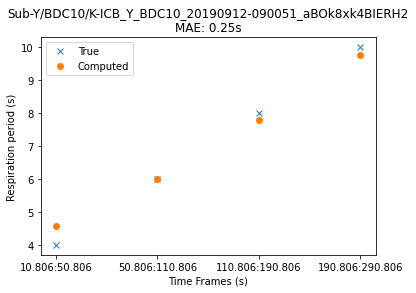

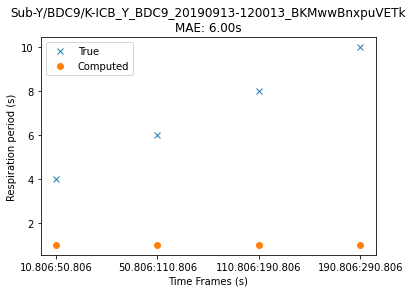

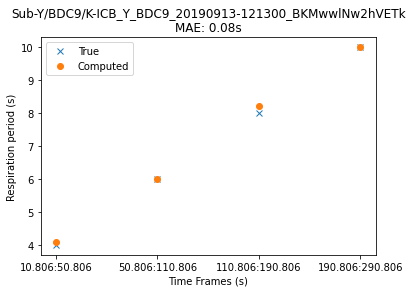

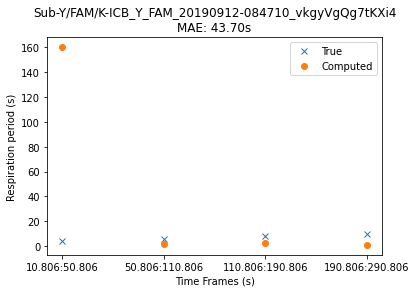

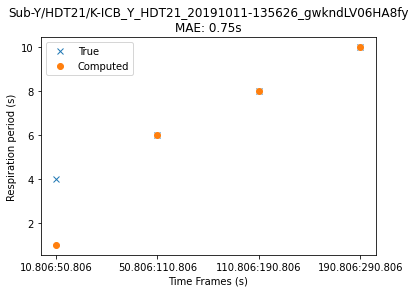

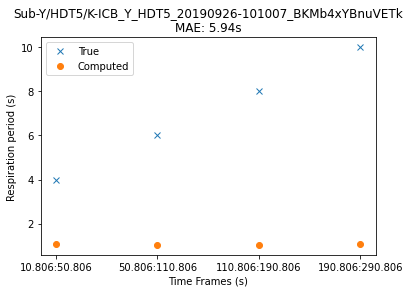

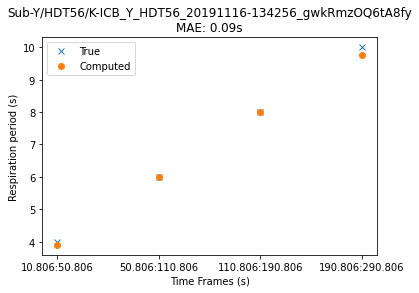

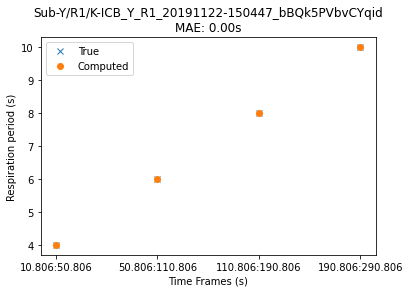

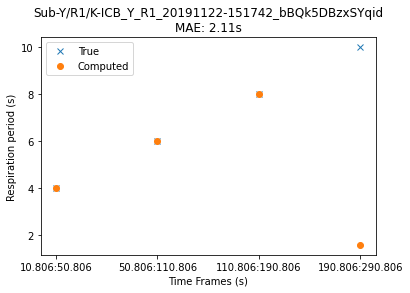

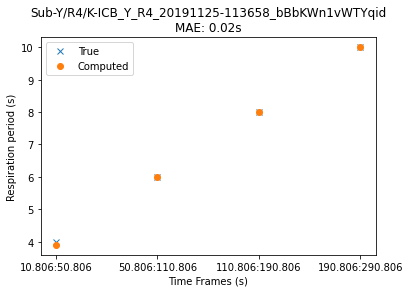

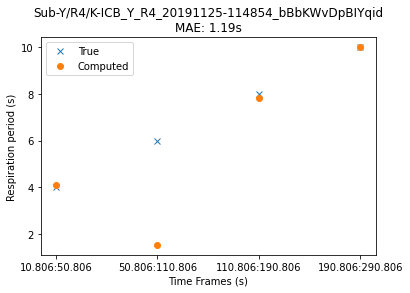

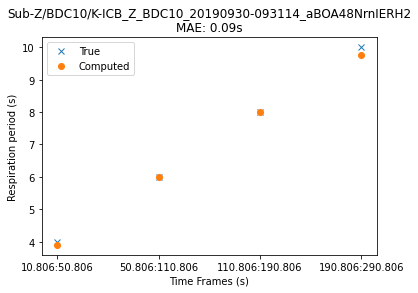

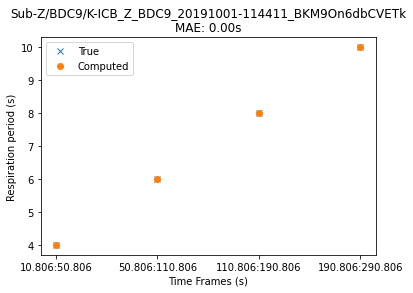

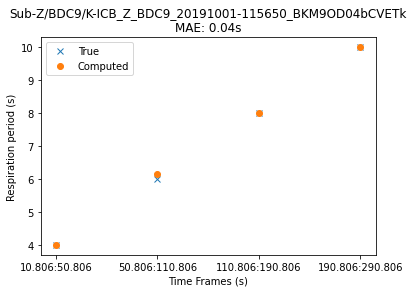

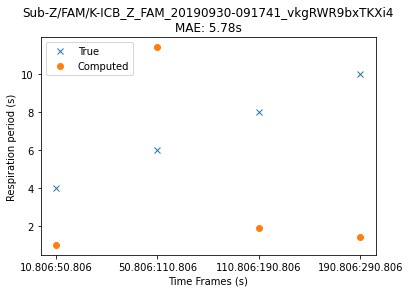

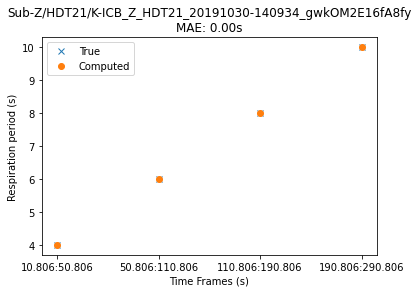

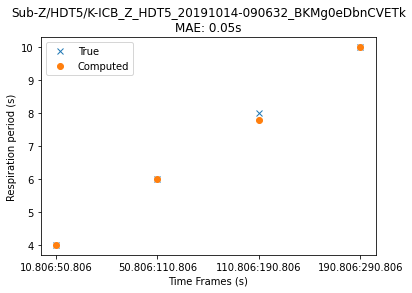

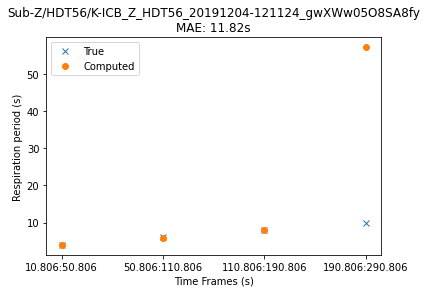

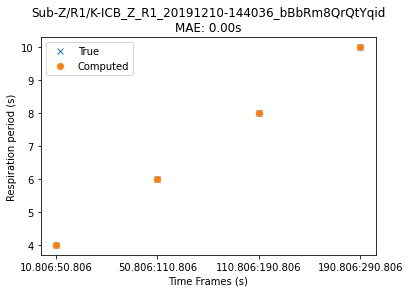

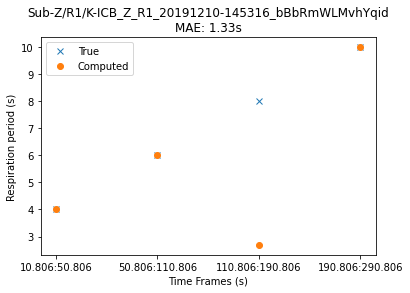

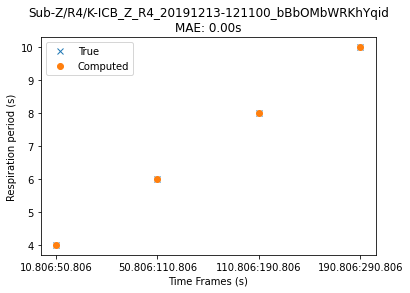

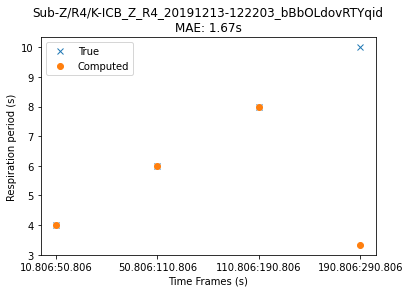

In [11]:
sec_path_all = []
err_all = []

for idx, i in enumerate(path_all):
    print(idx)
    record = read_record(i)
    scg = record.signals["scg"]
    s6 = detrend(scg.vel[1][:,2])
    resp_period_all_comp = []
    for k in time_frames:
        scg_cut = s6[int(k[0]*fs):int(k[1]*fs)]
        fpcntile, mpf, fmax, Ptotal, f, P = psd2(scg_cut-np.mean(scg_cut), fs=fs, nfft=8*np.ceil(len(scg_cut)/2), show=False)
        f_cut = np.where(f<=1)
        P_01 = P[f_cut]
        f_max01 = f[np.argmax(P_01)]
        resp_period = 1/f_max01
        resp_period_all_comp.append(resp_period)
    main_path = os.path.normpath(i)
    sec_path = main_path.split(os.sep)
    sec_path = sec_path[7]+'/'+sec_path[8]+'/'+sec_path[9]
    sec_path_all.append(sec_path)
    resp_period_all_true = [4, 6, 8, 10]
    err = mean_absolute_error(resp_period_all_true, resp_period_all_comp)
    err_all.append(err)
    plt.figure()
    x = np.array([0,1,2,3])
    my_xticks = ['10.806:50.806','50.806:110.806','110.806:190.806','190.806:290.806']
    plt.xticks(x, my_xticks)
    plt.plot(my_xticks, resp_period_all_true, 'x')
    plt.plot(my_xticks, resp_period_all_comp, 'o')
    plt.xlabel('Time Frames (s)')
    plt.ylabel("Respiration period (s)")
    plt.legend(['True', 'Computed'])
    plt.title(sec_path+ '\nMAE: ' +str(format(err, ".2f"))+ 's')

Text(0, 0.5, 'MAE (s)')

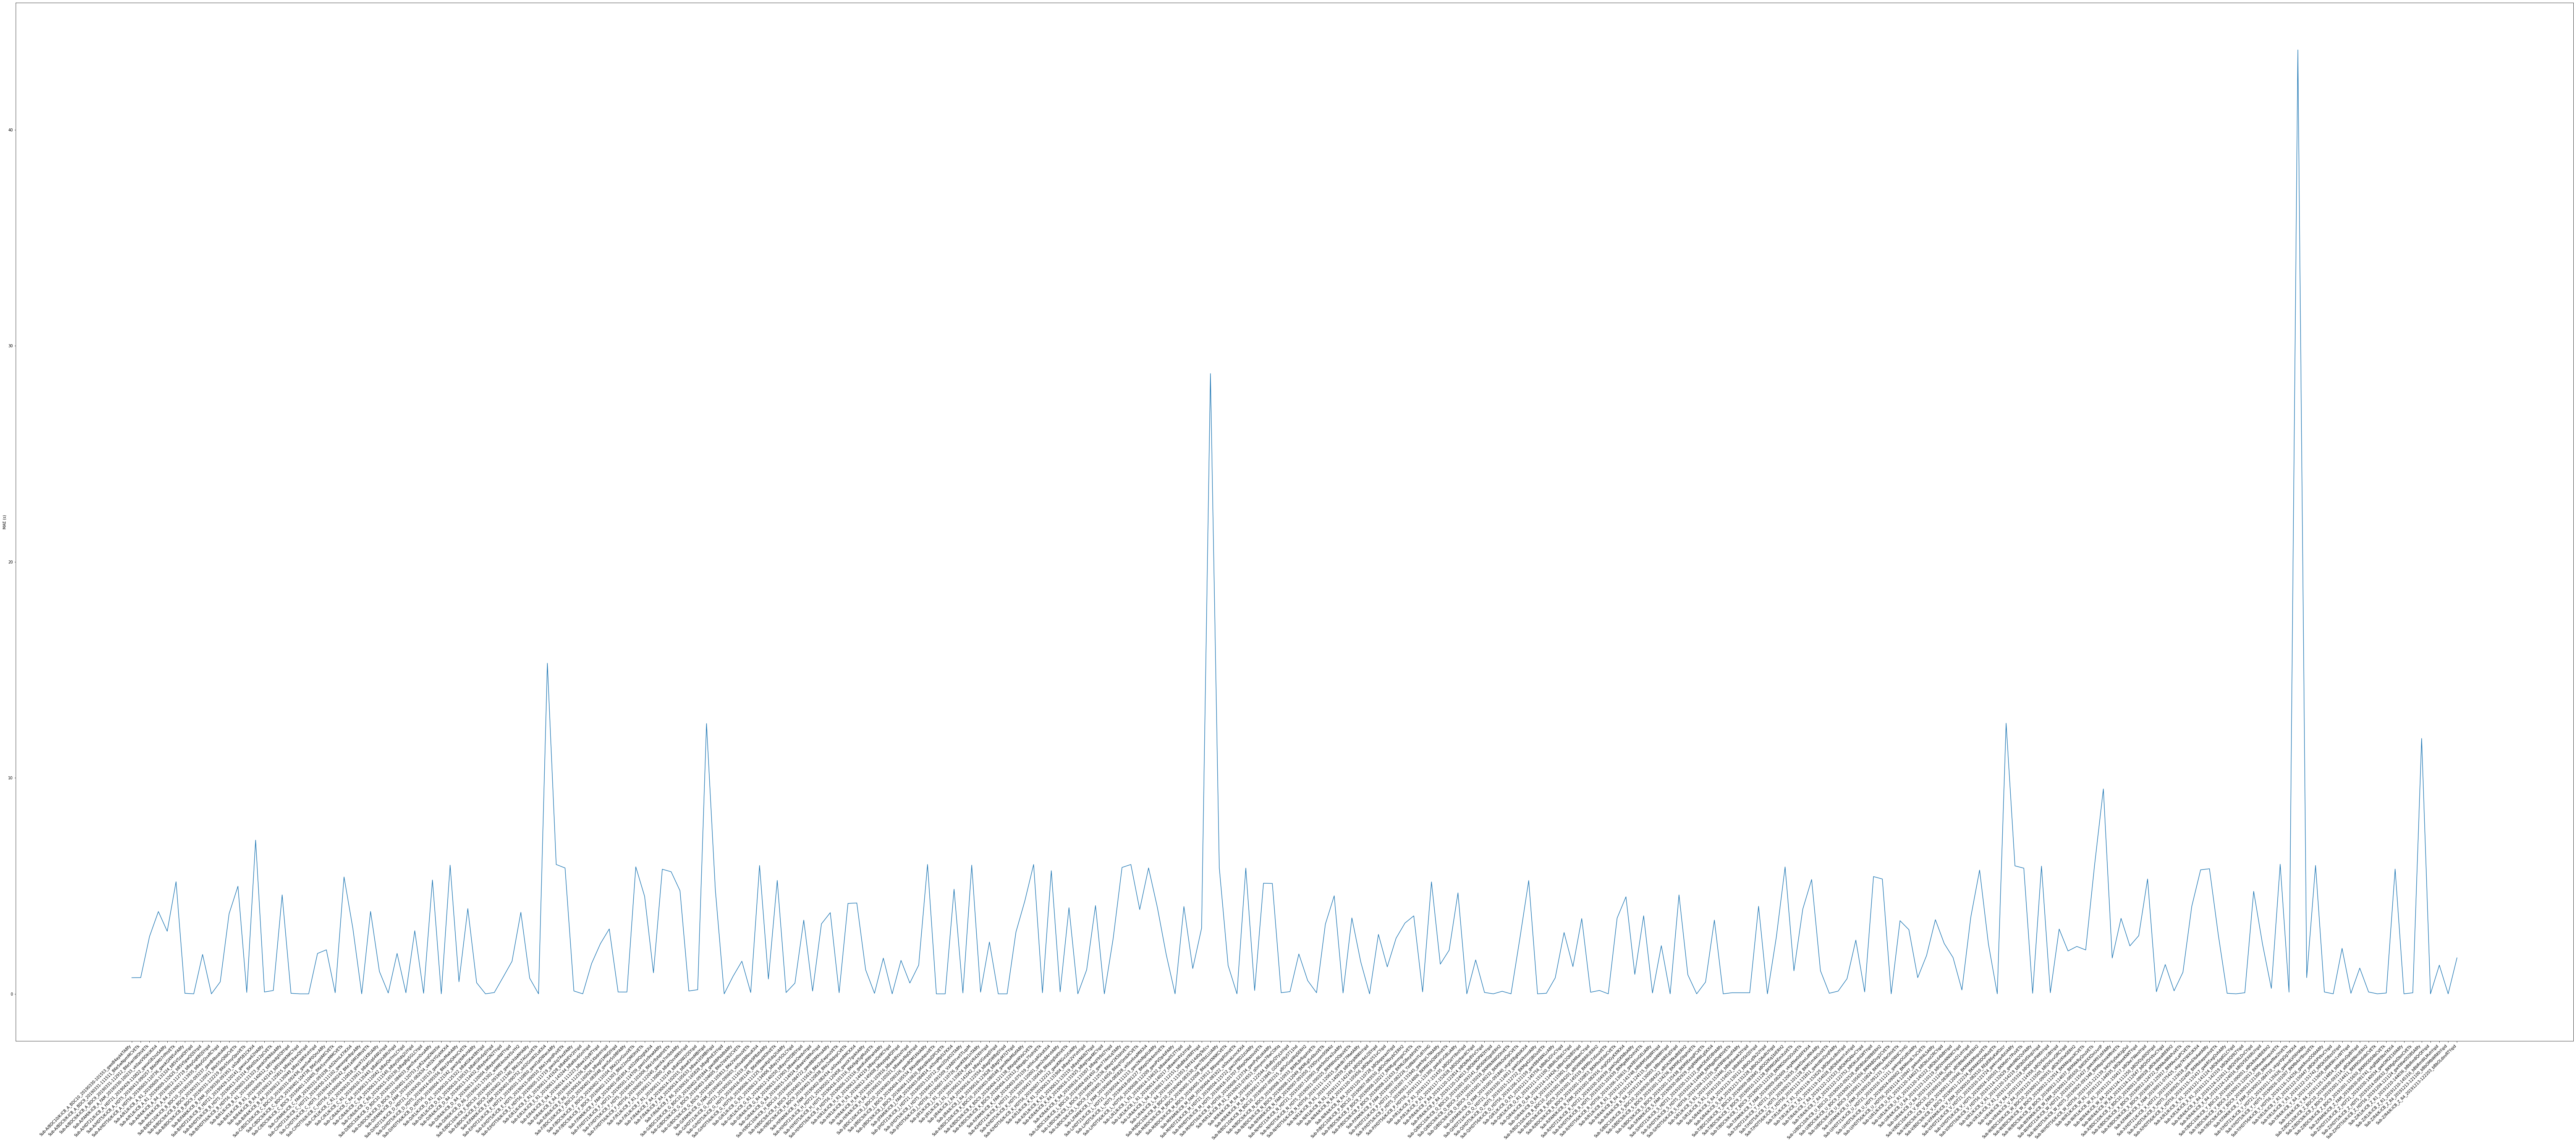

In [12]:
plt.figure(figsize=(120, 50))
x = np.array(range(len(sec_path_all)))
my_xticks = sec_path_all
plt.xticks(x, my_xticks, rotation=45, ha="right")
plt.plot(my_xticks, err_all)
plt.ylabel("MAE (s)")

In [13]:
import pickle

with open("/home/giuseppeditursi/Desktop/Respiration_from_SCG/2_Resp_Extraction/2_PSD_01/PSD01_err_all", "wb") as fp:   #Pickling
    pickle.dump(err_all, fp)